In [ ]:
import numpy as np
from math import *
import matplotlib.pylab as plt
import pandas as pd
from pathlib import Path
import matplotlib.colors
import xlsxwriter
import seaborn as sns

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
csfont = {'fontname':'Times New Roman'}

In [ ]:
path_to_ser = Path(r'/Users/maryiakalinina/Desktop/INDIA_DATA.xlsx')
df_ues = pd.read_excel(path_to_ser, sheet_name='Physical properties', skiprows=3)
df_ues.head()
df_ues.tail(4)

,№,Well,Formation,Gross Lithology,Plug No.,Plug Depth (m),Diameter (mm),Length (mm),Weight (g),Porosity (%),...,"Average, %.4","RMS, %.4","Average, %.5","RMS, %.5","Average, %.6","RMS, %.6","Average, %.7","RMS, %.7","Average, %.8","RMS, %.8"
61,62.0,NaN,Lodhika,Gabbro,L-68,2972.99,25.66,28.459999,39.720001,3.615941,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaN,Samples were destroyed during measurements at ...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,NaN,NaN,NaN,NaN,Sample broke in half before starts of experime...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_ues=df_ues.drop([62, 63, 64]) # убрать строки с комментариями

In [ ]:
df_and = df_ues[(df_ues['Thermophysical group'] == 'Qz(a)')]
x_val_dqza, y_val_dqza = df_and["Hydrostatic"], df_and["λ dry, W/(m·K)"]

In [ ]:
df_and = df_ues[(df_ues['Thermophysical group'] == 'Qz(b)')]
x_val_dqzb, y_val_dqzb = df_and["Hydrostatic"], df_and["λ dry, W/(m·K)"]

In [ ]:
df_andS = df_ues[(df_ues['Thermophysical group'] != 'Clay') & (df_ues['Thermophysical group'] != 'Gabbro') & (df_ues['Thermophysical group'] != 'Basalt')]
x_val_sandstone, y_val_sandstone = df_andS["Hydrostatic"], df_andS["λ dry, W/(m·K)"]

In [ ]:
def Likhteneker(phi, lam):

    lst = []
    for i, j in zip(phi, lam):
        sum = i*log(j)
        lst.append(sum)

    L_likht = 1
    for i in lst:
        L_likht *= np.exp(i)
#     print('TC Likhteneker: ', L_likht)
    return L_likht



def upper_winner(phi, lam):
    lst = []
    for i, j in zip(phi, lam):
        sum = i * j
        lst.append(sum)

    Up_W = 0
    for i in lst:
        Up_W += i
#     print('TC Upper Wiener: ', Up_W)
    return Up_W


def lower_winner(phi, lam):
    lst = []
    for i, j in zip(phi, lam):
        sum = i / j
        lst.append(sum)

    Lo_W = 0
    for i in lst:
        Lo_W += i
    Lo_W **=-1
#     print('TC Lower Wiener: ', Lo_W)
    return Lo_W

def Average_Winner(phi, lam):
    return np.mean([upper_winner(phi, lam), lower_winner(phi, lam)])


def Upper_Hashin_Strikman(phi, lam):
    L0 = max(lam)
    f = 1 / 3  # Границы ХШ - частный случай ОСП, тело сравние - мин.матрица=верхняя граница; флюид=нижняя граница.
                # Все включения только сферические АО=1, F деполяризации 1/3
    HS_comp1, HS_comp2 = [], []

    for i, j in zip(phi, lam):
        termc_3 = i * j / (L0 * (1-f)+j * f)
        termz_3 = i / (L0 * (1-f)+j * f)

        termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
        termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

        termc_all = (termc_3+2 * termc_12) / 3
        termz_all = (termz_3+2 * termz_12) / 3

        t16 = termc_all
        t15 = termz_all

        HS_comp1.append(t16)  # параллельная компонента ТС
        HS_comp2.append(t15)  # перпендикулярная компонента ТС
    i = 0
    for k in HS_comp1:
        i += k
    j = 0
    for k in HS_comp2:
        j += k

    L_eff = i / j
    # print('TC Upper Hashin-Strikman:', L_eff)
    return L_eff


def Lower_Hashin_Strikman(phi, lam):
    L0 = min(lam)
    f = 1 / 3  # Границы ХШ - частный случай ОСП, тело сравние - мин.матрица=верхняя граница; флюид=нижняя граница.
                # Все включения только сферические АО=1, F деполяризации 1/3
    HS_comp1, HS_comp2 = [], []

    for i, j in zip(phi, lam):
        termc_3 = i * j / (L0 * (1-f)+j * f)
        termz_3 = i / (L0 * (1-f)+j * f)

        termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
        termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

        termc_all = (termc_3+2 * termc_12) / 3
        termz_all = (termz_3+2 * termz_12) / 3

        t16 = termc_all
        t15 = termz_all

        HS_comp1.append(t16)  # параллельная компонента ТС
        HS_comp2.append(t15)  # перпендикулярная компонента ТС
    i = 0
    for k in HS_comp1:
        i += k
    j = 0
    for k in HS_comp2:
        j += k

    L_eff = i / j
    return L_eff

def Average_Hashin_Strikman(phi, lam):
    return np.mean([Lower_Hashin_Strikman(phi, lam), Upper_Hashin_Strikman(phi, lam)])



# Winner bourders

In [ ]:
lam = [7.00, 0.025]
porosity = np.linspace(0, 0.2, 200)

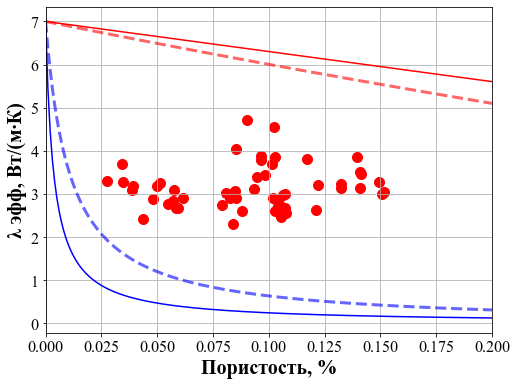

In [ ]:
tc_wn_up, tc_wn_dw = [], []
tc_hs_up, tc_hs_dw = [], []

for i in porosity:
    conc = [1-i, i]
    tc_wn_up.append(upper_winner(conc, lam))
    tc_wn_dw.append(lower_winner(conc, lam))

    tc_hs_up.append(Upper_Hashin_Strikman(conc, lam))
    tc_hs_dw.append(Lower_Hashin_Strikman(conc, lam))



plt.figure(figsize=(8, 6))
plt.plot(porosity, tc_wn_up, c='red')
plt.plot(porosity, tc_wn_dw, c='blue')

plt.plot(porosity, tc_hs_up, 'r--', lw=3, alpha=0.6)
plt.plot(porosity, tc_hs_dw, 'b--', lw=3, alpha=0.6)
plt.xlim(porosity.min(), porosity.max())
plt.xticks(fontsize=16, **csfont)
plt.yticks(fontsize=16, **csfont)


plt.scatter(x=x_val_sandstone/100,
            y=y_val_sandstone,
            s=100,
            label='Qz(a)',
           color='red')
plt.ylabel('λ эфф, Вт/(м∙К)', fontsize=20, **csfont, fontweight='bold')
plt.xlabel('Пористость, %', fontsize=20, **csfont, fontweight='bold')

plt.grid()
plt.show()

In [ ]:
df_andD = df_ues[df_ues['Formation'] == 'Dhrangadhra']
x_Dhrangadhra, y_Dhrangadhra = df_andD["Hydrostatic"], df_andD["λ dry, W/(m·K)"]

df_andW = df_ues[df_ues['Formation'] == 'Wadhawan']
x_Wadhawan, y_Wadhawan = df_andW["Hydrostatic"], df_andW["λ dry, W/(m·K)"]

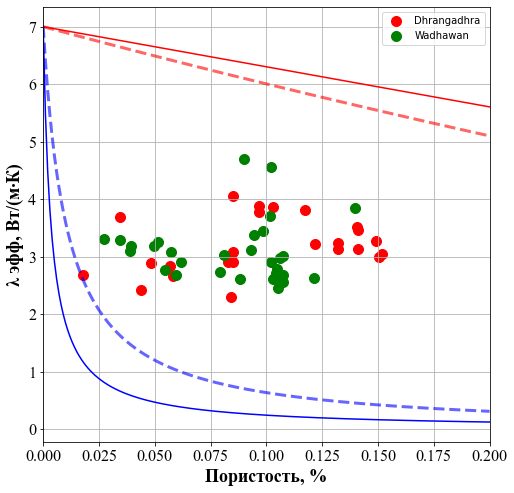

In [ ]:
tc_wn_up, tc_wn_dw = [], []
tc_hs_up, tc_hs_dw = [], []

for i in porosity:
    conc = [1-i, i]
    tc_wn_up.append(upper_winner(conc, lam))
    tc_wn_dw.append(lower_winner(conc, lam))

    tc_hs_up.append(Upper_Hashin_Strikman(conc, lam))
    tc_hs_dw.append(Lower_Hashin_Strikman(conc, lam))


plt.figure(figsize=(8, 8))
plt.plot(porosity, tc_wn_up, c='red')
plt.plot(porosity, tc_wn_dw, c='blue')

plt.plot(porosity, tc_hs_up, 'r--', lw=3, alpha=0.6)
plt.plot(porosity, tc_hs_dw, 'b--', lw=3, alpha=0.6)
plt.xlim(porosity.min(), porosity.max())
plt.xticks(fontsize=16, **csfont)
plt.yticks(fontsize=16, **csfont)


plt.scatter(x=x_Dhrangadhra/100,
            y=y_Dhrangadhra,
            s=100,
            label='Dhrangadhra',
           color='red')

plt.scatter(x=x_Wadhawan/100,
            y=y_Wadhawan,
            s=100,
            label='Wadhawan',
           color='green')

plt.ylabel('λ эфф, Вт/(м∙К)', fontsize=18, **csfont, fontweight='bold')
plt.xlabel('Пористость, %', fontsize=18, **csfont, fontweight='bold')
plt.legend()
plt.grid()
plt.show()

In [ ]:
df_ues.sort_values(by=['Refined lithology'], inplace=True)
# df.sort_values(by=['Year', 'Brand'], inplace=True)

In [ ]:
df_ues

,№,Well,Formation,Gross Lithology,Plug No.,Plug Depth (m),Diameter (mm),Length (mm),Weight (g),Porosity (%),...,"Average, %.4","RMS, %.4","Average, %.5","RMS, %.5","Average, %.6","RMS, %.6","Average, %.7","RMS, %.7","Average, %.8","RMS, %.8"
0,1.0,LODHIKA 1,Deccan trap,Weatherd basalt,L-1,279.73,25.530001,28.660000,37.650002,1.768120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,NaN,Deccan trap,Basalt,L-3,472.05,25.610001,26.740000,35.950001,2.662976,...,6.04,0.38,1.08,0.11,9.30,0.65,0.65,0.19,48.00,2.08
1,2.0,NaN,Deccan trap,Weatherd basalt,L-2,280.04,25.540001,26.000000,33.320000,2.787322,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,59.0,NaN,Dhrangadhra,Maroon Claystone,L-65,2667.30,25.620001,27.940001,39.400002,1.277368,...,3.99,2.20,0.44,0.07,4.55,0.40,0.48,0.09,53.73,1.63
42,43.0,NaN,Dhrangadhra,Sandstone,L-44,2056.58,25.590000,27.969999,35.230000,8.124850,...,0.07,0.05,0.09,0.03,1.39,0.50,0.24,0.09,51.58,0.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,53.0,NaN,Dhrangadhra,Sandstone,L-57,2410.25,25.650000,26.709999,33.900002,8.244941,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,58.0,NaN,Dhrangadhra,Ferruginised Sandy Siltstone,L-62,2412.10,25.650000,27.910000,37.049999,4.226965,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,52.0,NaN,Dhrangadhra,Sandstone,L-54,2329.50,25.620001,27.219999,35.549999,5.314555,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,51.0,NaN,Dhrangadhra,Sandstone,L-53,2329.10,25.610001,27.820000,37.099998,4.226108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_quartz = df_ues[df_ues['Refined lithology'].str.contains('Quartz')]
df_pink = df_ues[(df_ues['Refined lithology'].str.contains('pink')) & (df_ues['Refined lithology'].str.contains('Quartz')==False)]



# df[(df['col_name'].str.contains('apple')) & (df['col_name'].str.contains('banana'))]

df_gray = df_ues[df_ues['Refined lithology'].str.contains('Quartz|basalt|clay|Gabbro|red|Silty')==False]
df_red = df_ues[df_ues['Refined lithology'].str.contains('Quartz|basalt|clay|Gabbro|gray|Silty')==False]

# df[df["col"].str.contains('this|that')==False]
# df[(df['col_name'].str.contains('apple')) & (df['col_name'].str.contains('banana'))]

In [ ]:
df_pink[['Plug No.', 'Formation', 'Gross Lithology', 'Refined lithology']]
# df_new = df[['points', 'blocks']]

,Plug No.,Formation,Gross Lithology,Refined lithology
41,L-43,Dhrangadhra,Sandstone,"Sandstone, gray with a pink shade, fine-graine..."
33,L-35,Wadhawan,Sandstone,"Sandstone, gray with a pink shade, fine-graine..."
40,L-42,Dhrangadhra,Sandstone,"Sandstone, gray with a pink shade, fine-graine..."
32,L-34,Wadhawan,Sandstone,"Sandstone, gray with a pink shade, fine-graine..."
39,L-41,Dhrangadhra,Sandstone,"Sandstone, gray with a pink shade, fine-graine..."
37,L-39,Dhrangadhra,Sandstone,"Sandstone, gray with a pink shade, fine-graine..."
38,L-40,Dhrangadhra,Sandstone,"Sandstone, gray with a pink shade, fine-graine..."
36,L-38,Dhrangadhra,Sandstone,"Sandstone, gray with a pink shade, fine-graine..."


In [ ]:
x_quartz, y_quartz = df_quartz["Hydrostatic"], df_quartz["λ dry, W/(m·K)"]
x_gray, y_gray = df_gray["Hydrostatic"], df_gray["λ dry, W/(m·K)"]
x_red, y_red = df_red["Hydrostatic"], df_red["λ dry, W/(m·K)"]

x_pink, y_pink = df_pink["Hydrostatic"], df_pink["λ dry, W/(m·K)"] # опциональный варианть - роховые входят в серые песчаники

In [ ]:
y_quartz.describe()

count    12.000000
mean      3.870112
std       0.414642
min       3.270733
25%       3.652554
50%       3.831833
75%       3.922497
max       4.704900
Name: λ dry, W/(m·K), dtype: float64

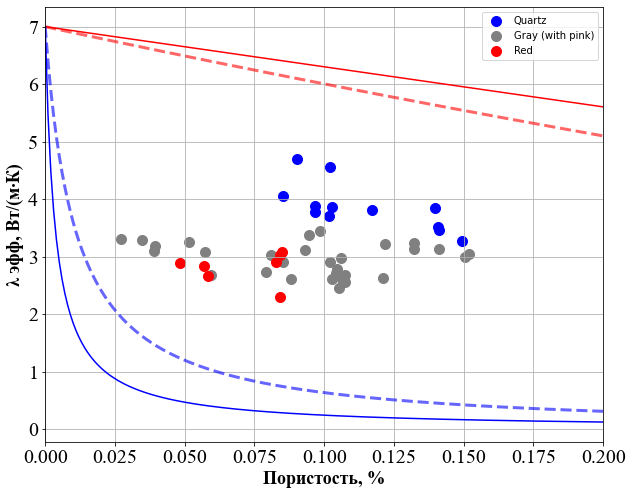

In [ ]:
tc_wn_up, tc_wn_dw = [], []
tc_hs_up, tc_hs_dw = [], []

for i in porosity:
    conc = [1-i, i]
    tc_wn_up.append(upper_winner(conc, lam))
    tc_wn_dw.append(lower_winner(conc, lam))

    tc_hs_up.append(Upper_Hashin_Strikman(conc, lam))
    tc_hs_dw.append(Lower_Hashin_Strikman(conc, lam))


plt.figure(figsize=(10, 8))
plt.plot(porosity, tc_wn_up, c='red')
plt.plot(porosity, tc_wn_dw, c='blue')

plt.plot(porosity, tc_hs_up, 'r--', lw=3, alpha=0.6)
plt.plot(porosity, tc_hs_dw, 'b--', lw=3, alpha=0.6)
plt.xlim(porosity.min(), porosity.max())
plt.xticks(fontsize=20, **csfont)
plt.yticks(fontsize=20, **csfont)


plt.scatter(x=x_quartz/100,
            y=y_quartz,
            s=100,
            label='Quartz',
           color='blue')

plt.scatter(x=x_gray/100,
            y=y_gray,
            s=100,
            label='Gray (with pink)',
           color='Gray')

plt.scatter(x=x_red/100,
            y=y_red,
            s=100,
            label='Red',
           color='Red')

plt.ylabel('λ эфф, Вт/(м∙К)', fontsize=18, **csfont, fontweight='bold')
plt.xlabel('Пористость, %', fontsize=18, **csfont, fontweight='bold')
plt.legend()
plt.grid()
plt.show()

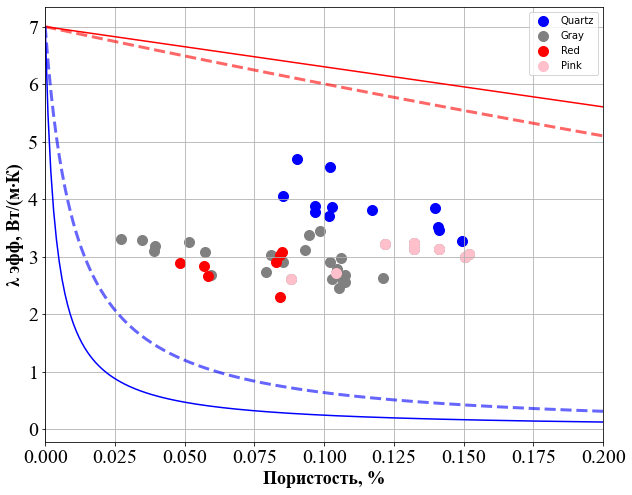

In [ ]:
tc_wn_up, tc_wn_dw = [], []
tc_hs_up, tc_hs_dw = [], []

for i in porosity:
    conc = [1-i, i]
    tc_wn_up.append(upper_winner(conc, lam))
    tc_wn_dw.append(lower_winner(conc, lam))

    tc_hs_up.append(Upper_Hashin_Strikman(conc, lam))
    tc_hs_dw.append(Lower_Hashin_Strikman(conc, lam))


plt.figure(figsize=(10, 8))
plt.plot(porosity, tc_wn_up, c='red')
plt.plot(porosity, tc_wn_dw, c='blue')

plt.plot(porosity, tc_hs_up, 'r--', lw=3, alpha=0.6)
plt.plot(porosity, tc_hs_dw, 'b--', lw=3, alpha=0.6)
plt.xlim(porosity.min(), porosity.max())
plt.xticks(fontsize=20, **csfont)
plt.yticks(fontsize=20, **csfont)


plt.scatter(x=x_quartz/100,
            y=y_quartz,
            s=100,
            label='Quartz',
           color='blue')

plt.scatter(x=x_gray/100,
            y=y_gray,
            s=100,
            label='Gray',
           color='Gray')

plt.scatter(x=x_red/100,
            y=y_red,
            s=100,
            label='Red',
           color='Red')

plt.scatter(x=x_pink/100,
            y=y_pink,
            s=100,
            label='Pink',
           color='Pink')

plt.ylabel('λ эфф, Вт/(м∙К)', fontsize=18, **csfont, fontweight='bold')
plt.xlabel('Пористость, %', fontsize=18, **csfont, fontweight='bold')
plt.legend()
plt.grid()
plt.show()

/var/folders/71/576pb5p91h58_y0m8bdv80380000gn/T/ipykernel_20276/2578003924.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig1.tight_layout(pad=8.0)


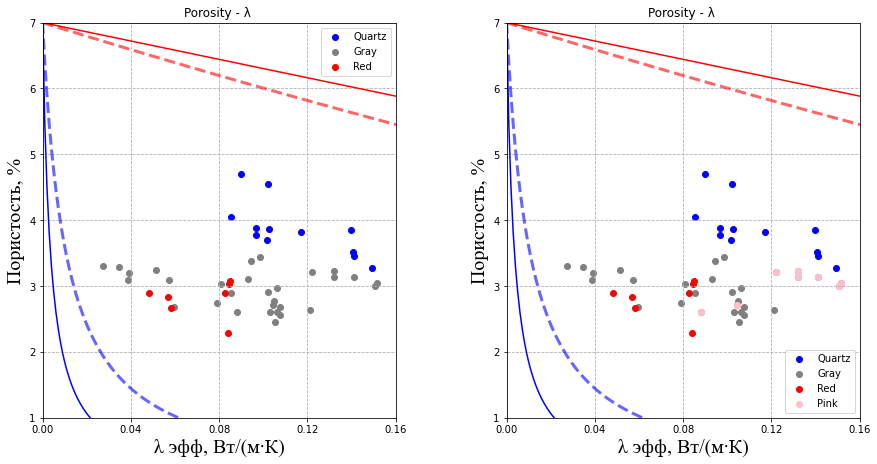

In [ ]:
fig1 = plt.figure(layout='constrained', figsize=(14, 8))
axs = fig1.subplots(1, 2, sharex=True)
fig1.tight_layout(pad=8.0)

tc_wn_up, tc_wn_dw = [], []
tc_hs_up, tc_hs_dw = [], []

for i in porosity:
    conc = [1-i, i]
    tc_wn_up.append(upper_winner(conc, lam))
    tc_wn_dw.append(lower_winner(conc, lam))


    tc_hs_up.append(Upper_Hashin_Strikman(conc, lam))
    tc_hs_dw.append(Lower_Hashin_Strikman(conc, lam))


for ax in axs:
#     ax.set_title(f'linear_width={a0:.3g}')
    ax.set_title(f'Porosity - λ ')
    ax.scatter(x_quartz/100, y_quartz, label='Quartz',color='blue')
    ax.scatter(x_gray/100, y_gray, label='Gray',color='gray')
    ax.scatter(x_red/100, y_red, label='Red',color='Red')

    ax.plot(porosity, tc_wn_up, c='red')
    ax.plot(porosity, tc_wn_dw, c='blue')
    ax.plot(porosity, tc_hs_up, 'r--', lw=3, alpha=0.6)
    ax.plot(porosity, tc_hs_dw, 'b--', lw=3, alpha=0.6)

    ax.set_xlabel('λ эфф, Вт/(м∙К)', fontsize=20, **csfont)
    ax.set_ylabel('Пористость, %', fontsize=20, **csfont)

#     ax.set_xscale('log', base=2)
    ax.grid(which='major', axis='both', linestyle='--')
    ax.legend(loc='best', fontsize='medium')
    ax.set_xlim([0, 0.16])
    ax.set_ylim([2, 7])

    ax.set_xticks(np.arange(0, 0.17, 0.04), fontsize=20, **csfont)
    ax.set_yticks(np.arange(1, 7.1, 1), fontsize=20, **csfont)

axs[1].scatter(x_pink/100, y_pink, label='Pink',color='Pink')
axs[1].legend(loc='best', fontsize='medium')


## Cross-plot Porosity - Permeability (with gross lithology)

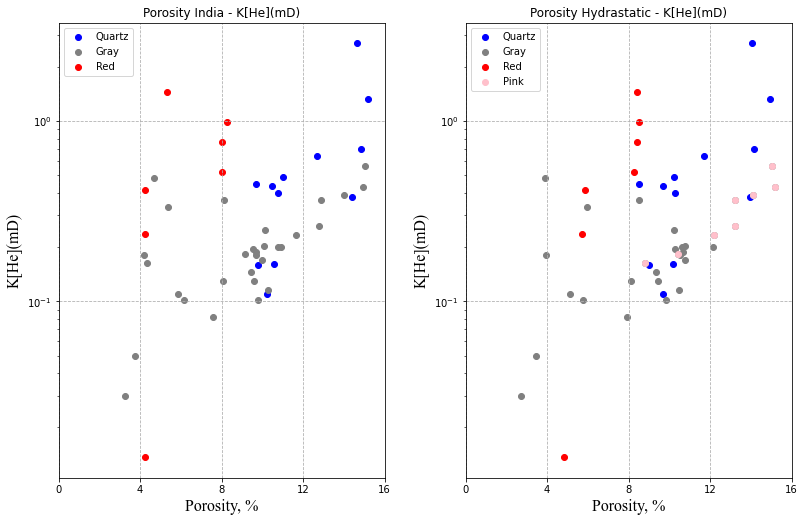

In [ ]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 2, figsize=(12, 8))
figure.tight_layout(pad=5.0)

# For Sine Function
x_value, y_value = 'Porosity (%)', 'K[He](mD)'
axis[0].scatter(df_quartz[x_value], df_quartz[y_value], label='Quartz',color='blue')
axis[0].scatter(df_gray[x_value], df_gray[y_value], label='Gray',color='gray')
axis[0].scatter(df_red[x_value], df_red[y_value], label='Red',color='Red')
axis[0].set_title("Porosity India - K[He](mD)")
axis[0].grid(which='major', axis='both', linestyle='--')
axis[0].set_xlabel('Porosity, %', fontsize=16, **csfont)
axis[0].set_ylabel('K[He](mD)', fontsize=16, **csfont)
axis[0].set_yscale('log', base=10)
axis[0].set_xlim([0, 16])
axis[0].set_xticks(np.arange(0, 17, 4), fontsize=20, **csfont)
axis[0].legend(loc='best', fontsize='medium')

# For Cosine Function
x_value, y_value = 'Hydrostatic', 'K[He](mD)'
axis[1].scatter(df_quartz[x_value], df_quartz[y_value], label='Quartz',color='blue')
axis[1].scatter(df_gray[x_value], df_gray[y_value], label='Gray',color='gray')
axis[1].scatter(df_red[x_value], df_red[y_value], label='Red',color='Red')
axis[1].scatter(df_pink[x_value], df_pink[y_value], label='Pink',color='Pink')
axis[1].set_title("Porosity Hydrastatic - K[He](mD)")
axis[1].grid(which='major', axis='both', linestyle='--')
axis[1].set_xlabel('Porosity, %', fontsize=16, **csfont)
axis[1].set_ylabel('K[He](mD)', fontsize=16, **csfont)
axis[1].set_yscale('log', base=10)
axis[1].set_xlim([0, 16])
axis[1].set_xticks(np.arange(0, 17, 4), fontsize=20, **csfont)
axis[1].legend(loc='best', fontsize='medium')

plt.show()

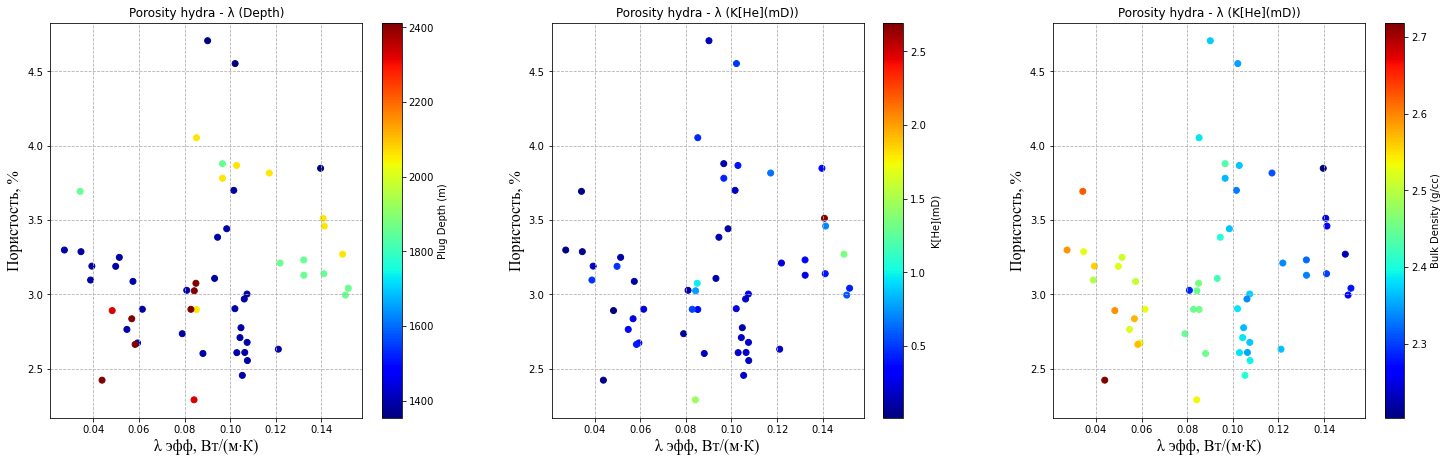

In [ ]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 3, figsize=(22, 8))
figure.tight_layout(pad=8.0)

z1=axis[0].scatter(x_val_sandstone/100, y_val_sandstone, c=df_andS['Plug Depth (m)'], cmap='jet')
axis[0].set_title("Porosity hydra - λ (Depth)")
axis[0].grid(which='major', axis='both', linestyle='--')
axis[0].set_xlabel('λ эфф, Вт/(м∙К)', fontsize=16, **csfont)
axis[0].set_ylabel('Пористость, %', fontsize=16, **csfont)
plt.colorbar(z1, ax=axis[0], label='Plug Depth (m)')

# For Cosine Function
z2 = axis[1].scatter(x_val_sandstone/100, y_val_sandstone, c=df_andS['K[He](mD)'], cmap='jet')
axis[1].set_title("Porosity hydra - λ (K[He](mD))")
axis[1].grid(which='major', axis='both', linestyle='--')
axis[1].grid(which='major', axis='both', linestyle='--')
axis[1].set_xlabel('λ эфф, Вт/(м∙К)', fontsize=16, **csfont)
axis[1].set_ylabel('Пористость, %', fontsize=16, **csfont)
plt.colorbar(z2, ax=axis[1], label='K[He](mD)')


# For2Cosine Function
z3 = axis[2].scatter(x_val_sandstone/100, y_val_sandstone, c=df_andS['Bulk Density (g/cc)'], cmap='jet')
axis[2].set_title("Porosity hydra - λ (K[He](mD))")
axis[2].grid(which='major', axis='both', linestyle='--')
axis[2].grid(which='major', axis='both', linestyle='--')
axis[2].set_xlabel('λ эфф, Вт/(м∙К)', fontsize=16, **csfont)
axis[2].set_ylabel('Пористость, %', fontsize=16, **csfont)
plt.colorbar(z3, ax=axis[2], label='Bulk Density (g/cc)')
plt.show()

In [ ]:
x, y = 'Porosity (%)', 'K ∞(mD)'
df_andD = df_ues[df_ues['Formation'] == 'Dhrangadhra']
x_Dhrangadhra, y_Dhrangadhra = df_andD[x], df_andD[y]

df_andW = df_ues[df_ues['Formation'] == 'Wadhawan']
x_Wadhawan, y_Wadhawan = df_andW[x], df_andW[y]


x1, y1 = 'Porosity (%)', 'K[He](mD)'
df_andD1 = df_ues[df_ues['Formation'] == 'Dhrangadhra']
x1_Dhrangadhra, y1_Dhrangadhra = df_andD1[x1], df_andD1[y1]

df_andW1 = df_ues[df_ues['Formation'] == 'Wadhawan']
x1_Wadhawan, y1_Wadhawan = df_andW1[x1], df_andW1[y1]


x2, y2 = 'Hydrostatic', 'K[He](mD)'
df_andD2 = df_ues[df_ues['Formation'] == 'Dhrangadhra']
x2_Dhrangadhra, y2_Dhrangadhra = df_andD2[x2], df_andD2[y2]

df_andW2 = df_ues[df_ues['Formation'] == 'Wadhawan']
x2_Wadhawan, y2_Wadhawan = df_andW2[x2], df_andW2[y2]

## Comparison Porosity India (gas) - Porosity Hydrostatic metthod

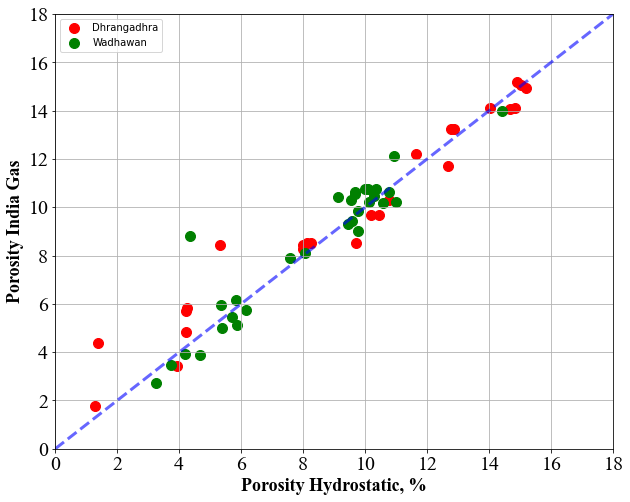

In [ ]:
plt.figure(figsize=(10, 8))
figure.tight_layout(pad=8.0)

plt.plot(np.linspace(0, 18, 34), np.linspace(0, 18, 34), 'b--', lw=3, alpha=0.6)
plt.xlim(0, 18)
plt.ylim(0,18)
plt.xticks(fontsize=20, **csfont)
plt.yticks(fontsize=20, **csfont)


plt.scatter(x=x1_Dhrangadhra,
            y=x2_Dhrangadhra,
            s=100,
            label='Dhrangadhra',
           color='red')

plt.scatter(x=x1_Wadhawan,
            y=x2_Wadhawan,
            s=100,
            label='Wadhawan',
           color='green')

plt.ylabel('Porosity India Gas', fontsize=18, **csfont, fontweight='bold')
plt.xlabel('Porosity Hydrostatic, %', fontsize=18, **csfont, fontweight='bold')
plt.legend()
plt.grid()
plt.show()

## Cross-plot Porosity - Permeability (with formation)

Коэффициенты в уравнении [-3.53814671  0.20328321] [[ 0.64398268 -0.04823472]
 [-0.04823472  0.00374929]]
Коэффициент корреляции 0.3085485404347535
Значимость по Пирсону (для линейной корреляции) (0.30854854043475355, 0.02190954730035914)


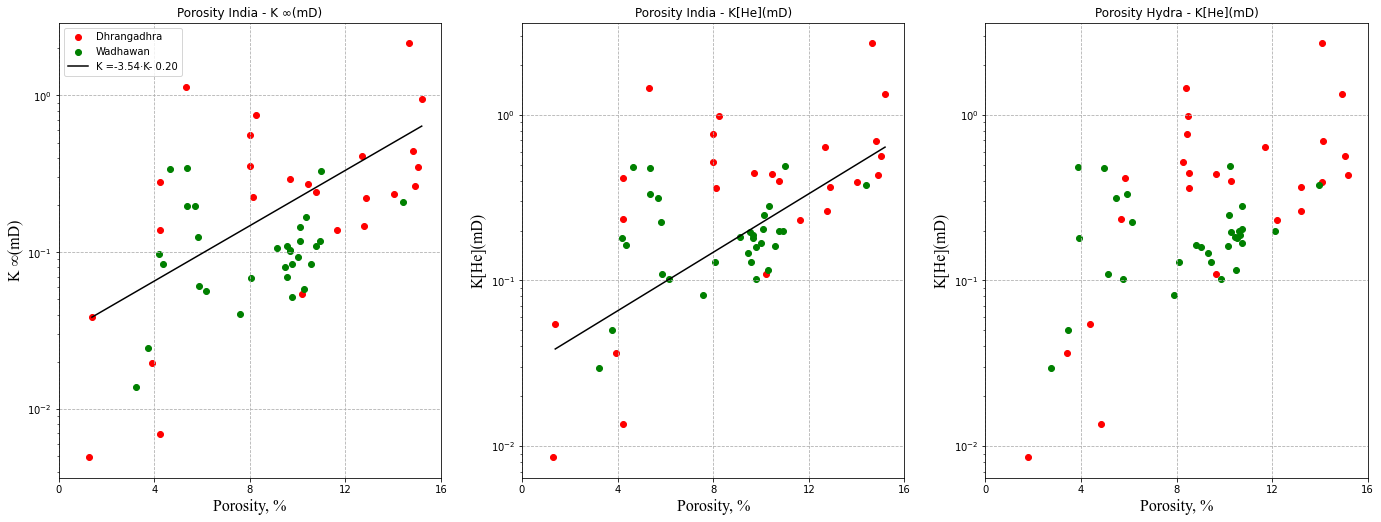

In [ ]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 3, figsize=(20, 8))
figure.tight_layout(pad=5.0)


import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b):
#     return a * x - b
    return np.exp(a+b*x)
#     return a+b*np.log(x)

sorted_df = df_andS.sort_values(by='Porosity (%)') # df_andS - только песчаники
xdata, ydata = sorted_df["Porosity (%)"], sorted_df["K ∞(mD)"]
popt, pcov = curve_fit(func, xdata, ydata)
print('Коэффициенты в уравнении', popt, pcov) # коэффициенты в уравнении
print('Коэффициент корреляции', np.corrcoef(xdata, ydata)[0, 1])
from scipy.stats.stats import pearsonr
print('Значимость по Пирсону (для линейной корреляции)', pearsonr(xdata, ydata))


axis[0].scatter(x=x_Dhrangadhra, y=y_Dhrangadhra, label='Dhrangadhra', color='red')
axis[0].scatter(x=x_Wadhawan, y=y_Wadhawan, label='Wadhawan',color='green')
axis[0].plot(xdata, func(xdata, *popt), 'k-', label='K =%5.2f·K-%5.2f' % tuple(popt))
axis[0].set_title("Porosity India - K ∞(mD)")
axis[0].grid(which='major', axis='both', linestyle='--')
axis[0].set_xlabel('Porosity, %', fontsize=16, **csfont)
axis[0].set_ylabel('K ∞(mD)', fontsize=16, **csfont)
axis[0].set_xlim([0, 16])
axis[0].set_xticks(np.arange(0, 17, 4), fontsize=20, **csfont)
axis[0].legend(loc='best', fontsize='medium')
axis[0].set_yscale('log', base=10)



# For Cosine Function
axis[1].scatter(x=x1_Dhrangadhra, y=y1_Dhrangadhra, label='Dhrangadhra', color='red')
axis[1].scatter(x=x1_Wadhawan, y=y1_Wadhawan, label='Wadhawan',color='green')
axis[1].plot(xdata, func(xdata, *popt), 'k-', label='γ =%5.2f·K-%5.2f' % tuple(popt))
axis[1].set_title("Porosity India - K[He](mD)")
axis[1].grid(which='major', axis='both', linestyle='--')
axis[1].set_xlabel('Porosity, %', fontsize=16, **csfont)
axis[1].set_ylabel('K[He](mD)', fontsize=16, **csfont)
axis[1].set_xlim([0, 16])
axis[1].set_xticks(np.arange(0, 17, 4), fontsize=20, **csfont)
axis[1].set_yscale('log', base=10)

# For2Cosine Function
axis[2].scatter(x=x2_Dhrangadhra, y=y2_Dhrangadhra, label='Dhrangadhra', color='red')
axis[2].scatter(x=x2_Wadhawan, y=y2_Wadhawan, label='Wadhawan',color='green')
axis[2].set_title("Porosity Hydra - K[He](mD)")
axis[2].grid(which='major', axis='both', linestyle='--')
axis[2].set_xlabel('Porosity, %', fontsize=16, **csfont)
axis[2].set_ylabel('K[He](mD)', fontsize=16, **csfont)
axis[2].set_yscale('log', base=10)

axis[2].set_xlim([0, 16])
# axis[2].set_ylim([2, 7])
axis[2].set_xticks(np.arange(0, 17, 4), fontsize=20, **csfont)
# axis[2].set_yticks(np.arange(1, 7.1, 1), fontsize=20, **csfont)

plt.show()

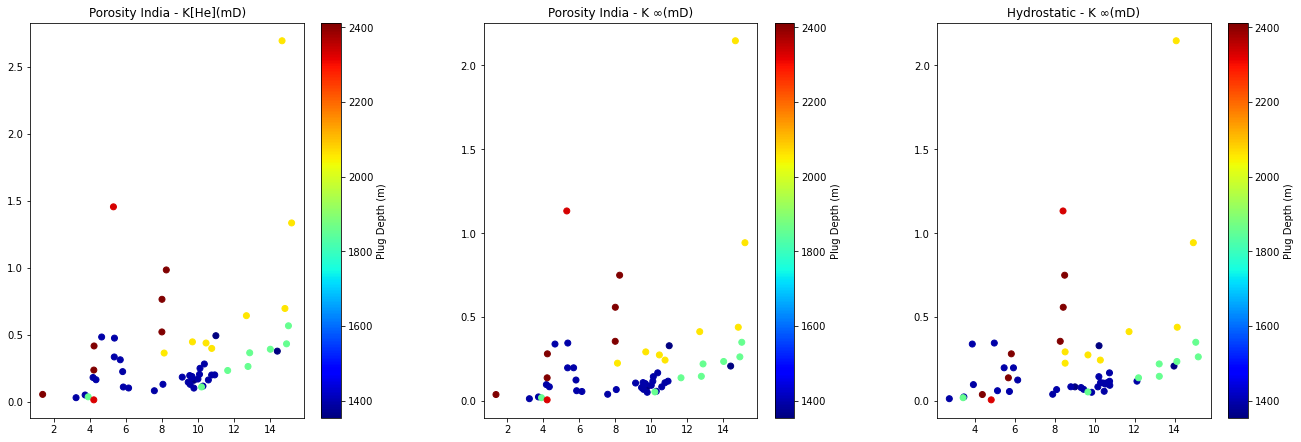

In [ ]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 3, figsize=(20, 8))
figure.tight_layout(pad=8.0)

# For Sine Function
z1 = axis[0].scatter(x=df_andS['Porosity (%)'], y=df_andS['K[He](mD)'], c=df_andS['Plug Depth (m)'], cmap='jet')
axis[0].set_title("Porosity India - K[He](mD)")
plt.colorbar(z1, ax=axis[0], label='Plug Depth (m)')

z2 = axis[1].scatter(x=df_andS['Porosity (%)'], y=df_andS['K ∞(mD)'], c=df_andS['Plug Depth (m)'], cmap='jet')
axis[1].set_title("Porosity India - K ∞(mD)")
plt.colorbar(z2, ax=axis[1], label='Plug Depth (m)')

z3 = axis[2].scatter(x=df_andS['Hydrostatic'], y=df_andS['K ∞(mD)'], c=df_andS['Plug Depth (m)'], cmap='jet')
axis[2].set_title("Hydrostatic - K ∞(mD)")
plt.colorbar(z2, ax=axis[2], label='Plug Depth (m)')

plt.show()

# Граница Винера и Хашина-Штрикмана для теплпроводности для песчаников: (1) без разделения, (2) с разделение на теплофическиее группы

### Разделение по формациям

In [ ]:
porosity = np.linspace(0, 0.2, 200)

In [ ]:
# Без разделения по формациям
df_andS = df_ues[(df_ues['Thermophysical group'] != 'Clay') & (df_ues['Thermophysical group'] != 'Gabbro') & (df_ues['Thermophysical group'] != 'Basalt')]
x_val_sandstone, y_val_sandstone = df_andS["Hydrostatic"], df_andS["λ dry, W/(m·K)"]


# С разделением по формациям
df_andD = df_ues[(df_ues['Formation'].str.contains('Dhrangadhra')) & (df_ues['Thermophysical group'].str.contains('Clay')==False)]
x_Dhrangadhra, y_Dhrangadhra = df_andD["Hydrostatic"], df_andD["λ dry, W/(m·K)"]

df_andW = df_ues[df_ues['Formation'] == 'Wadhawan']
x_Wadhawan, y_Wadhawan = df_andW["Hydrostatic"], df_andW["λ dry, W/(m·K)"]

In [ ]:
df_andD[['Plug No.', 'Formation', 'Gross Lithology', 'Refined lithology']].head()

,Plug No.,Formation,Gross Lithology,Refined lithology
42,L-44,Dhrangadhra,Sandstone,"Feldspar-quartz sandstone, light gray to white..."
34,L-36,Dhrangadhra,Sandstone,"Quartz sandstone, gray with a pink shade, fine..."
49,L-51,Dhrangadhra,Sandstone,"Quartz sandstone, light gray to white, medium-..."
48,L-50,Dhrangadhra,Sandstone,"Quartz sandstone, light gray to white, medium-..."
47,L-49,Dhrangadhra,Sandstone,"Quartz sandstone, light gray to white, medium-..."


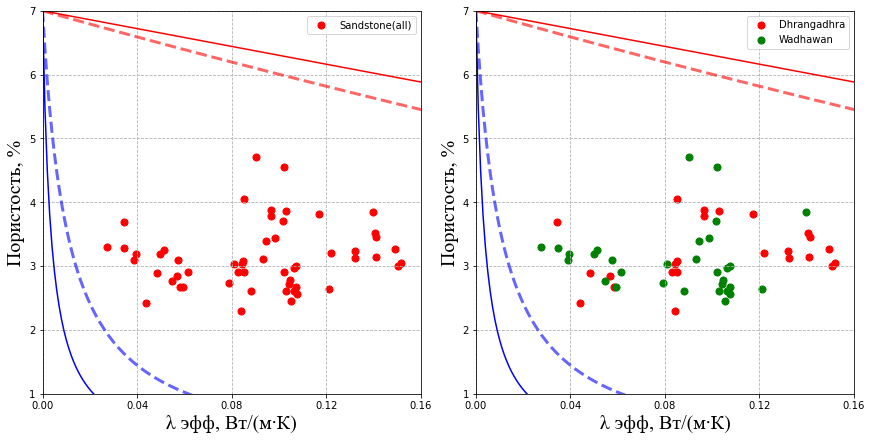

In [ ]:
fig = plt.figure(layout='constrained', figsize=(12, 6))
axs = fig.subplots(1, 2, sharex=True)
# fig.tight_layout(pad=8.0)

tc_wn_up, tc_wn_dw = [], []
tc_hs_up, tc_hs_dw = [], []

lam = [7.00, 0.025]
for i in porosity:
    conc = [1-i, i]
    tc_wn_up.append(upper_winner(conc, lam))
    tc_wn_dw.append(lower_winner(conc, lam))

    tc_hs_up.append(Upper_Hashin_Strikman(conc, lam))
    tc_hs_dw.append(Lower_Hashin_Strikman(conc, lam))


for ax in axs:
#     ax.set_title(f'linear_width={a0:.3g}')
#     ax.set_title(f'Porosity - λ ')

    ax.plot(porosity, tc_wn_up, c='red')
    ax.plot(porosity, tc_wn_dw, c='blue')
    ax.plot(porosity, tc_hs_up, 'r--', lw=3, alpha=0.6)
    ax.plot(porosity, tc_hs_dw, 'b--', lw=3, alpha=0.6)

    ax.set_xlabel('λ эфф, Вт/(м∙К)', fontsize=20, **csfont)
    ax.set_ylabel('Пористость, %', fontsize=20, **csfont)

#     ax.set_xscale('log', base=2)
    ax.grid(which='major', axis='both', linestyle='--')
    ax.set_xlim([0, 0.16])
    ax.set_ylim([2, 7])

    ax.set_xticks(np.arange(0, 0.17, 0.04), fontsize=20, **csfont)
    ax.set_yticks(np.arange(1, 7.1, 1), fontsize=20, **csfont)


axs[0].scatter(x=x_val_sandstone/100, y=y_val_sandstone, s=50,color='red', label='Sandstone(all)')
axs[0].legend(loc='best', fontsize='medium')

axs[1].scatter(x=x_Dhrangadhra/100, y=y_Dhrangadhra, s=50, label='Dhrangadhra',color='red')
axs[1].scatter(x=x_Wadhawan/100, y=y_Wadhawan, s=50, label='Wadhawan', color='green')
axs[1].legend(loc='best', fontsize='medium')

plt.show()


### Разделение по литологии

In [ ]:
df_quartz = df_ues[df_ues['Refined lithology'].str.contains('Quartz')]
df_pink = df_ues[(df_ues['Refined lithology'].str.contains('pink')) & (df_ues['Refined lithology'].str.contains('Quartz')==False)]
df_gray = df_ues[df_ues['Refined lithology'].str.contains('Quartz|basalt|clay|Gabbro|red|Silty')==False]
df_red = df_ues[df_ues['Refined lithology'].str.contains('Quartz|basalt|clay|Gabbro|gray|Silty')==False]

In [ ]:
y_quartz.describe()

count    12.000000
mean      3.870112
std       0.414642
min       3.270733
25%       3.652554
50%       3.831833
75%       3.922497
max       4.704900
Name: λ dry, W/(m·K), dtype: float64

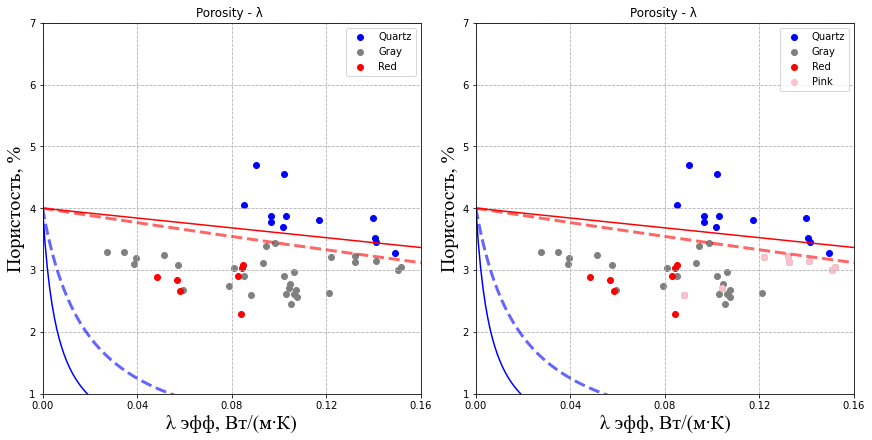

In [ ]:
fig1 = plt.figure(layout='constrained', figsize=(12, 6))
axs = fig1.subplots(1, 2, sharex=True)
# fig1.tight_layout(pad=8.0)

tc_wn_up, tc_wn_dw = [], []
tc_hs_up, tc_hs_dw = [], []

lam = [4.00, 0.025]
for i in porosity:
    conc = [1-i, i]
    tc_wn_up.append(upper_winner(conc, lam))
    tc_wn_dw.append(lower_winner(conc, lam))

    tc_hs_up.append(Upper_Hashin_Strikman(conc, lam))
    tc_hs_dw.append(Lower_Hashin_Strikman(conc, lam))


for ax in axs:
#     ax.set_title(f'linear_width={a0:.3g}')
    ax.set_title(f'Porosity - λ ')
    ax.scatter(x_quartz/100, y_quartz, label='Quartz',color='blue')
    ax.scatter(x_gray/100, y_gray, label='Gray',color='gray')
    ax.scatter(x_red/100, y_red, label='Red',color='Red')

    ax.plot(porosity, tc_wn_up, c='red')
    ax.plot(porosity, tc_wn_dw, c='blue')
    ax.plot(porosity, tc_hs_up, 'r--', lw=3, alpha=0.6)
    ax.plot(porosity, tc_hs_dw, 'b--', lw=3, alpha=0.6)

    ax.set_xlabel('λ эфф, Вт/(м∙К)', fontsize=20, **csfont)
    ax.set_ylabel('Пористость, %', fontsize=20, **csfont)

#     ax.set_xscale('log', base=2)
    ax.grid(which='major', axis='both', linestyle='--')
    ax.legend(loc='best', fontsize='medium')
    ax.set_xlim([0, 0.16])
    ax.set_ylim([2, 7])

    ax.set_xticks(np.arange(0, 0.17, 0.04), fontsize=20, **csfont)
    ax.set_yticks(np.arange(1, 7.1, 1), fontsize=20, **csfont)

axs[1].scatter(x_pink/100, y_pink, label='Pink',color='Pink')
axs[1].legend(loc='best', fontsize='medium')


## Границы с разделение по тепло-литологическим группам и λматрицы из уравнения регрессии "Пористость - теплопроводность"

In [ ]:
df_qza = df_ues[df_ues['Thermophysical group'] == 'Qz(a)']
df_qzb = df_ues[df_ues['Thermophysical group']==('Qz(b)')]
df_fspqz1 = df_ues[df_ues['Thermophysical group']==('Fsp-Qz(a)')]
df_fspqz2 = df_ues[df_ues['Thermophysical group']==('Fsp-Qz(b)')]
df_fspqz3= df_ues[df_ues['Thermophysical group']==('Fsp-Qz(c)')]

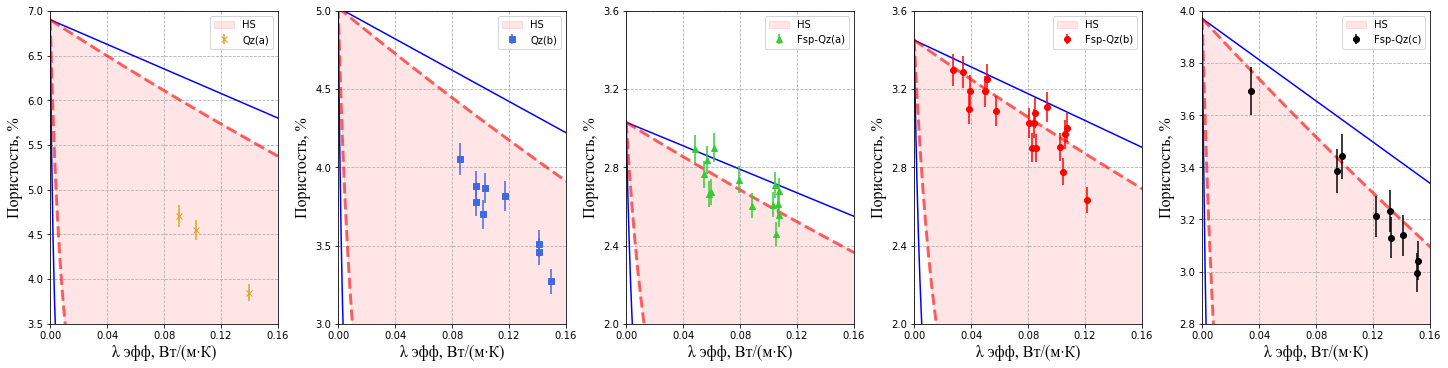

In [ ]:
fig2 = plt.figure(layout='constrained', figsize=(20, 5))
axs = fig2.subplots(1, 5, sharex=True)

fluid_lam=0.025
matrix_lam = [(6.90, fluid_lam), (5.02, fluid_lam),
              (3.03, fluid_lam), (3.45, fluid_lam),
              (3.97, fluid_lam)] # значение теплопровдности из уравненения регрессии


for ax, mlam in zip(axs, matrix_lam):

# for ax, (a0, base) in zip(axs, ((0.2, 2), (1.0, 0), (5.0, 10))):
#     ax.set_title(f'linear_width={a0:.3g}')
#     ax.set_title(f'Porosity - λ ')


    tc_wn_up, tc_wn_dw = [], []
    tc_hs_up, tc_hs_dw = [], []

    for i in porosity:
        conc = [1-i, i]
        tc_wn_up.append(upper_winner(conc, mlam))
        tc_wn_dw.append(lower_winner(conc, mlam))

        tc_hs_up.append(Upper_Hashin_Strikman(conc, mlam))
        tc_hs_dw.append(Lower_Hashin_Strikman(conc, mlam))

    ax.plot(porosity, tc_wn_up, c='blue')
    ax.plot(porosity, tc_wn_dw, c='blue')
    ax.plot(porosity, tc_hs_up, 'r--', lw=3, alpha=0.6)
    ax.plot(porosity, tc_hs_dw, 'r--', lw=3, alpha=0.6)
    ax.fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1, label='HS')

    ax.set_xlabel('λ эфф, Вт/(м∙К)', fontsize=16, **csfont)
    ax.set_ylabel('Пористость, %', fontsize=16, **csfont)

#     ax.set_xscale('log', base=2)
    ax.grid(which='major', axis='both', linestyle='--')
#     ax.legend(loc='best', fontsize='medium')
    ax.set_xlim([0, 0.16])
    ax.set_ylim([2, 5])

    ax.set_xticks(np.arange(0, 0.17, 0.04), fontsize=20, **csfont)
    ax.set_yticks(np.arange(2, 5.1, 1), fontsize=20, **csfont)



x_value, y_value = 'Hydrostatic', 'λ dry, W/(m·K)'
error = 0.025 * df_qza[y_value]

# ci = 1.96 * np.std(df_qza[y_value])/np.sqrt(len(x=df_qza[y_value]))
# axs[0].fill_between(df_qza[x_value]/100, (y-3*ci), (y+3*ci), color='b', alpha=.1, label='Доверительный интервал (0.95)')

axs[0].errorbar(df_qza[x_value]/100, df_qza[y_value], label='Qz(a)', color='Goldenrod', yerr=error, fmt='x')
axs[0].legend(loc='best', fontsize='medium')
axs[0].set_ylim([3.5, 7])
axs[0].set_yticks(np.arange(3.5, 7.1, 0.5), fontsize=20, **csfont)

error = 0.025 * df_qzb[y_value]
axs[1].errorbar(df_qzb[x_value]/100, df_qzb[y_value], label='Qz(b)',color='RoyalBlue', yerr=error, fmt='s')
axs[1].legend(loc='best', fontsize='medium')
axs[1].set_ylim([3, 5])
axs[1].set_yticks(np.arange(3, 5.1, 0.5), fontsize=20, **csfont)

error = 0.025 * df_fspqz1[y_value]
axs[2].errorbar(df_fspqz1[x_value]/100, df_fspqz1[y_value], label='Fsp-Qz(a)',color='Limegreen', yerr=error, fmt='^')
axs[2].legend(loc='best', fontsize='medium')
axs[2].set_ylim([2, 3.6])
axs[2].set_yticks(np.arange(2, 3.7, 0.4), fontsize=20, **csfont)

error = 0.025 * df_fspqz2[y_value]
axs[3].errorbar(df_fspqz2[x_value]/100, df_fspqz2[y_value], label='Fsp-Qz(b)',color='Red', yerr=error, fmt='o')
axs[3].legend(loc='best', fontsize='medium')
axs[3].set_ylim([2, 3.6])
axs[3].set_yticks(np.arange(2, 3.7, 0.4), fontsize=20, **csfont)

error = 0.025 * df_fspqz3[y_value]
axs[4].errorbar(df_fspqz3[x_value]/100, df_fspqz3[y_value], label='Fsp-Qz(c)',color='Black', yerr=error, fmt='o')
axs[4].legend(loc='best', fontsize='medium')
axs[4].set_ylim([2.8, 4])
axs[4].set_yticks(np.arange(2.8, 4.1, 0.2), fontsize=20, **csfont)
plt.show()

In [ ]:
df_qz = df_ues[df_ues['Thermophysical group'].str.contains('Fsp|Basalt|Clay|Gabbro|Heterogeneous|Lithic')==False] # песчаники группы Qz(a, b)
df_fspqz = df_ues[df_ues['Thermophysical group'].str.contains('Fsp-Qz')] # песчаники группы fsp-qz(a, b, c)

In [ ]:
df_qz[['Plug No.', 'Formation', 'Gross Lithology', 'Refined lithology']]

,Plug No.,Formation,Gross Lithology,Refined lithology
6,L-7,Wadhawan,Sandstone,"Quartz sandstone, gray with a greenish shade, ..."
34,L-36,Dhrangadhra,Sandstone,"Quartz sandstone, gray with a pink shade, fine..."
3,L-4,Wadhawan,Sandstone,"Quartz sandstone, gray, fine-grained, massive"
4,L-5,Wadhawan,Sandstone,"Quartz sandstone, gray, fine-grained, massive"
5,L-6,Wadhawan,Sandstone,"Quartz sandstone, gray, fine-grained, massive"
49,L-51,Dhrangadhra,Sandstone,"Quartz sandstone, light gray to white, medium-..."
48,L-50,Dhrangadhra,Sandstone,"Quartz sandstone, light gray to white, medium-..."
47,L-49,Dhrangadhra,Sandstone,"Quartz sandstone, light gray to white, medium-..."
46,L-48,Dhrangadhra,Sandstone,"Quartz sandstone, light gray to white, medium-..."
45,L-47,Dhrangadhra,Sandstone,"Quartz sandstone, light gray to white, medium-..."


## ХШ для сухих

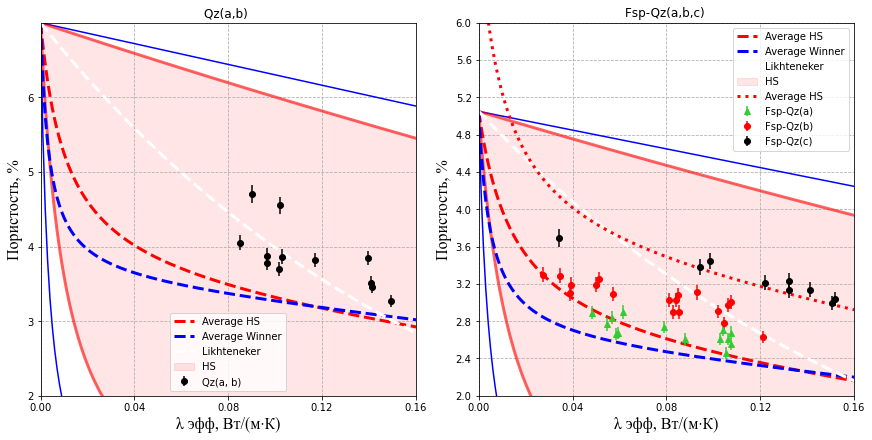

TC матрицы 4.4 
Среденее ошибка= 34.53 ,  СКО ошибка= 3.83
 
TC матрицы 4.8 
Среденее ошибка= 29.27 ,  СКО ошибка= 3.98
 
TC матрицы 5.4 
Среденее ошибка= 21.41 ,  СКО ошибка= 4.2
 


In [ ]:
fig4 = plt.figure(layout='constrained', figsize=(12, 6))
axs = fig4.subplots(1, 2, sharex=True)

fluid_lam=0.025
# matrix_lam = [(3.03, fluid_lam), (3.45, fluid_lam), (3.97, fluid_lam)] # из уравнения регрессии
matrix_lam = [(7.00, fluid_lam), (5.05, fluid_lam)] # подобранные из границ ХШ


for ax, mlam in zip(axs, matrix_lam):

    tc_lich = []
    tc_wn_up, tc_wn_dw, tc_wn_mean = [], [], []
    tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []

    for i in porosity:
        conc = [1-i, i]
        tc_wn_up.append(upper_winner(conc, mlam))
        tc_wn_dw.append(lower_winner(conc, mlam))
        tc_wn_mean.append(Average_Winner(conc, mlam))

        tc_hs_up.append(Upper_Hashin_Strikman(conc, mlam))
        tc_hs_dw.append(Lower_Hashin_Strikman(conc, mlam))
        tc_hs_mean.append(Average_Hashin_Strikman(conc, mlam))

        tc_lich.append(Likhteneker(conc, mlam))

    # ax.set_title(f'linear_width={a0:.3g}')
    # ax.set_title(f'Porosity - λ ')
    ax.plot(porosity, tc_wn_up, c='blue')
    ax.plot(porosity, tc_wn_dw, c='blue')
    ax.plot(porosity, tc_hs_up, 'r-', lw=3, alpha=0.6)
    ax.plot(porosity, tc_hs_dw, 'r-', lw=3, alpha=0.6)
    ax.plot(porosity, tc_hs_mean, 'r--', lw=3, alpha=1, label='Average HS')
    ax.plot(porosity, tc_wn_mean, 'b--', lw=3, alpha=1, label='Average Winner')
    ax.plot(porosity,  tc_lich, 'w--', lw=3, alpha=1, label='Likhteneker')

    ax.fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1, label='HS')


    ax.set_xlabel('λ эфф, Вт/(м∙К)', fontsize=16, **csfont)
    ax.set_ylabel('Пористость, %', fontsize=16, **csfont)
    ax.grid(which='major', axis='both', linestyle='--')
    ax.set_xlim([0, 0.16])
    ax.set_xticks(np.arange(0, 0.17, 0.04), fontsize=20, **csfont)

y_value  = 'λ dry, W/(m·K)'

error = 0.025 * df_qz[y_value]
axs[0].errorbar(df_qz[x_value]/100, df_qz[y_value], label='Qz(a, b)',color='Black', yerr=error, fmt='o')

axs[0].set_ylim([2, 7])
axs[0].set_yticks(np.arange(2, 7, 1), fontsize=20, **csfont)
axs[0].legend(loc='best', fontsize='medium')
axs[0].set_title(f'Qz(a,b) ')


# error = 0.025 * df_fspqz[y_value]
# axs[1].errorbar(df_fspqz[x_value]/100, df_fspqz[y_value], label='Fsp-Qz(a, b, c)',color='Black', yerr=error, fmt='o')

error = 0.025 * df_fspqz1[y_value]
axs[1].errorbar(df_fspqz1[x_value]/100, df_fspqz1[y_value], label='Fsp-Qz(a)',color='Limegreen', yerr=error, fmt='^')

error = 0.025 * df_fspqz2[y_value]
axs[1].errorbar(df_fspqz2[x_value]/100, df_fspqz2[y_value], label='Fsp-Qz(b)',color='Red', yerr=error, fmt='o')

error = 0.025 * df_fspqz3[y_value]
axs[1].errorbar(df_fspqz3[x_value]/100, df_fspqz3[y_value], label='Fsp-Qz(c)',color='Black', yerr=error, fmt='o')



mlam = [7, fluid_lam]
tc_hs_mean = []
for i in porosity:
    conc = [1-i, i]
    tc_hs_mean.append(Average_Hashin_Strikman(conc, mlam))
axs[1].plot(porosity, tc_hs_mean, 'r:', lw=3, alpha=1, label='Average HS')


axs[1].set_ylim([2, 6])
axs[1].set_yticks(np.arange(2, 6.1, 0.4), fontsize=20, **csfont)
axs[1].legend(loc='best', fontsize='medium')
axs[1].set_title(f'Fsp-Qz(a,b,c) ')
plt.show()

# Критерии статистического отбора λ матрицы по границам ХШ (среднее). Выбиралось то значение,
# где средняя ошибка (расхождение между тееорией) и СКО ошибки минимальные. Для группы мономиктовых песчаников
# λматрицы(по границам ХШ) = 6.90-7 , для олигомиктовых λматрицы = 5.7. Для мономиктовых песчаников значение совпадает/близкое
# со значением λматрицы из уравнения регрессии, а для олигомиктовых λматрицы сильно занижено при регрессионнном анализе, кроме того
# при решении обратной задачи для трех флюидов выялено, что для всех групп fsp-qz(a,b,c) λматрицы <5, дает расхождение между теорией и экспериментов
# от 10  до 30%!!! Поэтому, для получения более достоверных значений λматрицы используется критерий отбора по среднеей границе ХШ


# Большое расхождение между теорией и экспериментом при решении обратной задачи возникало из-за большего расхождения для воды и
# керосина - стабильные большие расхождения. Для высушенного состояния наблюдался большой диапазон в расхождении: от минимального
# до максимального, но значения для высушеного состояни выбирались по критерию с минимальным расхождение в сравнении с водой и
# керосином.

mlam = [(4.4, fluid_lam), (4.8, fluid_lam), (5.4, fluid_lam)]
for j in mlam:
    predicted, error = [], []
    sorted_df = df_fspqz3.sort_values(by='Hydrostatic')
    for i in sorted_df['Hydrostatic']/100:
        conc = [1-i, i]
        predicted.append(Average_Hashin_Strikman(conc, j))

    for i, k in zip(predicted, sorted_df['λ dry, W/(m·K)']):
        error.append((i-k)/k*100)

    print(f"TC матрицы {np.round(j[0], 2)} ")
    print('Среденее ошибка=', np.round(np.mean(np.abs(error)), 2),', ','СКО ошибка=', np.round(np.std(error), 2))
    print(f" ")

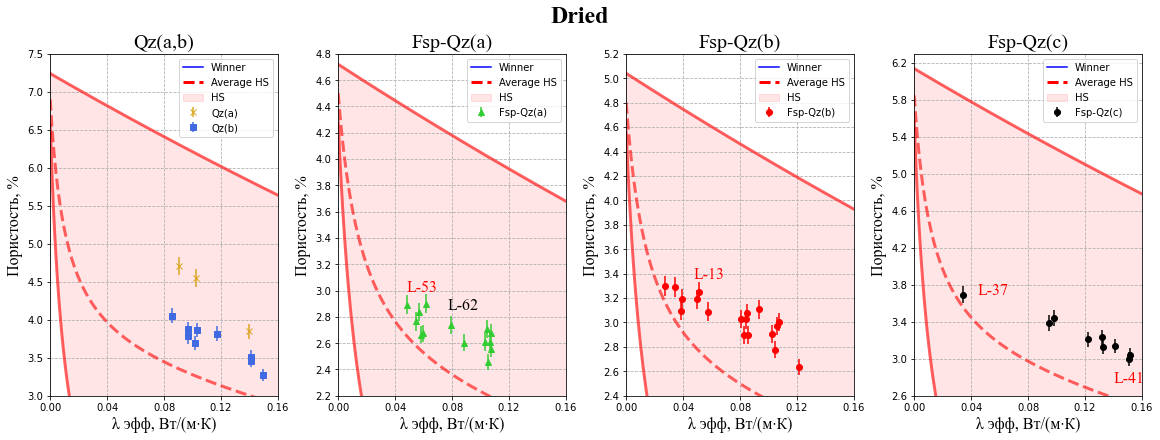

In [ ]:
fig4 = plt.figure(layout='constrained', figsize=(16, 6))
axs = fig4.subplots(1, 4, sharex=True)

fluid_lam=0.025
# matrix_lam = [(3.03, fluid_lam), (3.45, fluid_lam), (3.97, fluid_lam)] # из уравнения регрессии
matrix_lam = [(0.01, fluid_lam), (0.01, fluid_lam), (0.01, fluid_lam), (0.01, fluid_lam)] # подобранные из границ ХШ


for ax, mlam in zip(axs, matrix_lam):

    tc_lich = []
    tc_wn_up, tc_wn_dw, tc_wn_mean = [], [], []
    tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []

    for i in porosity:
        conc = [1-i, i]
        tc_wn_up.append(upper_winner(conc, mlam))
        tc_wn_dw.append(lower_winner(conc, mlam))
        tc_wn_mean.append(Average_Winner(conc, mlam))

        tc_hs_up.append(Upper_Hashin_Strikman(conc, mlam))
        tc_hs_dw.append(Lower_Hashin_Strikman(conc, mlam))
        tc_hs_mean.append(Average_Hashin_Strikman(conc, mlam))

        tc_lich.append(Likhteneker(conc, mlam))

    # ax.set_title(f'linear_width={a0:.3g}')
    # ax.set_title(f'Porosity - λ ')
    ax.plot(porosity, tc_wn_up, c='blue')
    ax.plot(porosity, tc_wn_dw, c='blue', label='Winner')
    ax.plot(porosity, tc_hs_up, 'r-', lw=3, alpha=0.6)
    ax.plot(porosity, tc_hs_dw, 'r-', lw=3, alpha=0.6)
    ax.plot(porosity, tc_hs_mean, 'r--', lw=3, alpha=1, label='Average HS')
#     ax.plot(porosity, tc_wn_mean, 'b--', lw=3, alpha=1, label='Average Winner')
#     ax.plot(porosity,  tc_lich, 'w--', lw=3, alpha=1, label='Likhteneker')

    ax.fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1, label='HS')


    ax.set_xlabel('λ эфф, Вт/(м∙К)', fontsize=16, **csfont)
    ax.set_ylabel('Пористость, %', fontsize=16, **csfont)
    ax.grid(which='major', axis='both', linestyle='--')
    ax.set_xlim([0, 0.16])
    ax.set_xticks(np.arange(0, 0.17, 0.04), fontsize=20, **csfont)

# y1_value,y2_value  = λ dry, W/(m·K)' ,'λ water, W/(m·K)', 'λ kerosene, W/(m·K)'
x_value, y_value = 'Hydrostatic', 'λ dry, W/(m·K)'
error = 0.025 * df_qza[y_value]
axs[0].errorbar(df_qza[x_value]/100, df_qza[y_value], label='Qz(a)', color='Goldenrod', yerr=error, fmt='x')

error = 0.025 * df_qzb[y_value]
axs[0].errorbar(df_qzb[x_value]/100, df_qzb[y_value], label='Qz(b)',color='RoyalBlue', yerr=error, fmt='s')

tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []
# mlam = ([4.6, 4.40])
mlam = ([7.24, 6.56])
for i in porosity:
    conc = [1-i, i]

    tc_hs_up.append(Upper_Hashin_Strikman(conc, (mlam[0],fluid_lam)))
    tc_hs_dw.append(Lower_Hashin_Strikman(conc, (mlam[1], fluid_lam)))
    tc_hs_mean.append(Average_Hashin_Strikman(conc, ((mlam[0]+mlam[1])*0.5, fluid_lam)))

axs[0].plot(porosity, tc_hs_up, 'r-', lw=3, alpha=0.6)
axs[0].plot(porosity, tc_hs_dw, 'r-', lw=3, alpha=0.6)
axs[0].plot(porosity, tc_hs_mean, 'r--', lw=3, alpha=0.6)
axs[0].fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1)

axs[0].set_ylim([3, 7])
axs[0].set_yticks(np.arange(3, 7.6, 0.5), fontsize=20, **csfont)
axs[0].legend(loc='best', fontsize='medium')
axs[0].set_title(f'Qz(a,b)', fontsize=20, **csfont)


# plot2
error = 0.025 * df_fspqz1[y_value]
axs[1].errorbar(df_fspqz1[x_value]/100, df_fspqz1[y_value], label='Fsp-Qz(a)',color='Limegreen', yerr=error, fmt='^')

tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []
# mlam = ([4.6, 4.40])
mlam = ([4.72, 4.28])
for i in porosity:
    conc = [1-i, i]

    tc_hs_up.append(Upper_Hashin_Strikman(conc, (mlam[0],fluid_lam)))
    tc_hs_dw.append(Lower_Hashin_Strikman(conc, (mlam[1], fluid_lam)))
    tc_hs_mean.append(Average_Hashin_Strikman(conc, ((mlam[0]+mlam[1])*0.5, fluid_lam)))

axs[1].plot(porosity, tc_hs_up, 'r-', lw=3, alpha=0.6)
axs[1].plot(porosity, tc_hs_dw, 'r-', lw=3, alpha=0.6)
axs[1].plot(porosity, tc_hs_mean, 'r--', lw=3, alpha=0.6)
axs[1].fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1)

axs[1].set_ylim([2.2, 4.8])
axs[1].set_yticks(np.arange(2.2, 4.81, 0.2), fontsize=20, **csfont)
axs[1].legend(loc='best', fontsize='medium')
axs[1].set_title(f'Fsp-Qz(a)',fontsize=20, **csfont)

x_selected, y_selected = df_fspqz1[(df_fspqz1['Plug No.'].str.contains('L-53'))][x_value]/100, df_fspqz1[(df_fspqz1['Plug No.'].str.contains('L-53'))][y_value]
axs[1].annotate('L-53', xy=(x_selected, y_selected+0.1), fontsize=16, **csfont, color='red')

x_selected, y_selected = df_fspqz1[(df_fspqz1['Plug No.'].str.contains('L-62'))][x_value]/100, df_fspqz1[(df_fspqz1['Plug No.'].str.contains('L-62'))][y_value]
axs[1].annotate('L-62', xy=(x_selected+0.02, y_selected+0.02), fontsize=16, **csfont)



# tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []
# for i in porosity:
#     conc = [1-i, i]

#     tc_hs_up.append(Upper_Hashin_Strikman(conc, (4.73,fluid_lam)))
#     tc_hs_dw.append(Lower_Hashin_Strikman(conc, (4.37, fluid_lam)))
# axs[1].plot(porosity, tc_hs_up, 'r-', lw=3, alpha=0.6)
# axs[1].plot(porosity, tc_hs_dw, 'r-', lw=3, alpha=0.6)
# axs[1].fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1, label='HS')


#plot3

error = 0.025 * df_fspqz2[y_value]
axs[2].errorbar(df_fspqz2[x_value]/100, df_fspqz2[y_value], label='Fsp-Qz(b)',color='Red', yerr=error, fmt='o')

tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []
# mlam = ([5.1, 4.5])
mlam = ([5.04, 4.56])

for i in porosity:
    conc = [1-i, i]

    tc_hs_up.append(Upper_Hashin_Strikman(conc, (mlam[0],fluid_lam)))
    tc_hs_dw.append(Lower_Hashin_Strikman(conc, (mlam[1], fluid_lam)))
    tc_hs_mean.append(Average_Hashin_Strikman(conc, ((mlam[0]+mlam[1])*0.5, fluid_lam)))

axs[2].plot(porosity, tc_hs_up, 'r-', lw=3, alpha=0.6)
axs[2].plot(porosity, tc_hs_dw, 'r-', lw=3, alpha=0.6)
axs[2].plot(porosity, tc_hs_mean, 'r--', lw=3, alpha=0.6)
axs[2].fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1)

axs[2].set_ylim([2.4,5.2])
axs[2].set_yticks(np.arange(2.4, 5.3, 0.2), fontsize=20, **csfont)
axs[2].legend(loc='best', fontsize='medium')
axs[2].set_title(f'Fsp-Qz(b)', fontsize=20, **csfont)


x_selected, y_selected = df_fspqz2[(df_fspqz2['Plug No.'].str.contains('L-13'))][x_value]/100, df_fspqz2[(df_fspqz2['Plug No.'].str.contains('L-13'))][y_value]
axs[2].annotate('L-13', xy=(x_selected+0.02, y_selected+0.06), fontsize=16, **csfont, color='red')



# tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []
# for i in porosity:
#     conc = [1-i, i]

#     tc_hs_up.append(Upper_Hashin_Strikman(conc, (4.73,fluid_lam)))
#     tc_hs_dw.append(Lower_Hashin_Strikman(conc, (4.37, fluid_lam)))
# axs[1].plot(porosity, tc_hs_up, 'r-', lw=3, alpha=0.6)
# axs[1].plot(porosity, tc_hs_dw, 'r-', lw=3, alpha=0.6)
# axs[1].fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1, label='HS')

# plot4
error = 0.025 * df_fspqz3[y_value]
axs[3].errorbar(df_fspqz3[x_value]/100, df_fspqz3[y_value], label='Fsp-Qz(c)',color='Black', yerr=error, fmt='o')

axs[3].set_ylim([2.6, 6.3])
axs[3].set_yticks(np.arange(2.6, 6.3, 0.4), fontsize=20, **csfont)
axs[3].legend(loc='best', fontsize='medium')
axs[3].set_title(f'Fsp-Qz(c)', fontsize=20, **csfont)

tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []
# mlam = ([5.1, 4.5])
mlam = ([6.14, 5.56])

for i in porosity:
    conc = [1-i, i]

    tc_hs_up.append(Upper_Hashin_Strikman(conc, (mlam[0],fluid_lam)))
    tc_hs_dw.append(Lower_Hashin_Strikman(conc, (mlam[1], fluid_lam)))
    tc_hs_mean.append(Average_Hashin_Strikman(conc, ((mlam[0]+mlam[1])*0.5, fluid_lam)))

axs[3].plot(porosity, tc_hs_up, 'r-', lw=3, alpha=0.6)
axs[3].plot(porosity, tc_hs_dw, 'r-', lw=3, alpha=0.6)
axs[3].plot(porosity, tc_hs_mean, 'r--', lw=3, alpha=0.6)
axs[3].fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1)

x_selected, y_selected = df_fspqz3[(df_fspqz3['Plug No.'].str.contains('L-37'))][x_value]/100, df_fspqz3[(df_fspqz3['Plug No.'].str.contains('L-37'))][y_value]
axs[3].annotate('L-37', xy=(x_selected+0.01, y_selected), fontsize=16, **csfont, color='red')

x_selected, y_selected = df_fspqz3[(df_fspqz3['Plug No.'].str.contains('L-41'))][x_value]/100, df_fspqz3[(df_fspqz3['Plug No.'].str.contains('L-41'))][y_value]
axs[3].annotate('L-41', xy=(x_selected-0.012, y_selected-0.3), fontsize=16, **csfont, color='red')


fig4.suptitle(f'Dried', weight='bold', fontsize=24, **csfont)
plt.show()


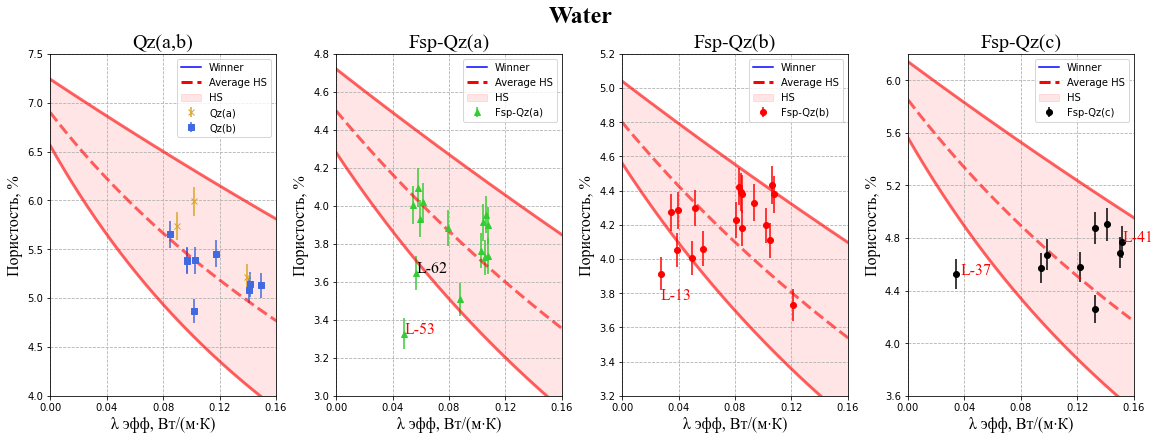

In [ ]:
fig4 = plt.figure(layout='constrained', figsize=(16, 6))
axs = fig4.subplots(1, 4, sharex=True)

fluid_lam=0.60
# matrix_lam = [(3.03, fluid_lam), (3.45, fluid_lam), (3.97, fluid_lam)] # из уравнения регрессии
matrix_lam = [(0.01, fluid_lam), (0.01, fluid_lam), (0.01, fluid_lam), (0.01, fluid_lam)] # подобранные из границ ХШ


for ax, mlam in zip(axs, matrix_lam):

    tc_lich = []
    tc_wn_up, tc_wn_dw, tc_wn_mean = [], [], []
    tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []

    for i in porosity:
        conc = [1-i, i]
        tc_wn_up.append(upper_winner(conc, mlam))
        tc_wn_dw.append(lower_winner(conc, mlam))
        tc_wn_mean.append(Average_Winner(conc, mlam))

        tc_hs_up.append(Upper_Hashin_Strikman(conc, mlam))
        tc_hs_dw.append(Lower_Hashin_Strikman(conc, mlam))
        tc_hs_mean.append(Average_Hashin_Strikman(conc, mlam))

        tc_lich.append(Likhteneker(conc, mlam))

    # ax.set_title(f'linear_width={a0:.3g}')
    # ax.set_title(f'Porosity - λ ')
    ax.plot(porosity, tc_wn_up, c='blue')
    ax.plot(porosity, tc_wn_dw, c='blue', label='Winner')
    ax.plot(porosity, tc_hs_up, 'r-', lw=3, alpha=0.6)
    ax.plot(porosity, tc_hs_dw, 'r-', lw=3, alpha=0.6)
    ax.plot(porosity, tc_hs_mean, 'r--', lw=3, alpha=1, label='Average HS')
#     ax.plot(porosity, tc_wn_mean, 'b--', lw=3, alpha=1, label='Average Winner')
#     ax.plot(porosity,  tc_lich, 'w--', lw=3, alpha=1, label='Likhteneker')

    ax.fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1, label='HS')


    ax.set_xlabel('λ эфф, Вт/(м∙К)', fontsize=16, **csfont)
    ax.set_ylabel('Пористость, %', fontsize=16, **csfont)
    ax.grid(which='major', axis='both', linestyle='--')
    ax.set_xlim([0, 0.16])
    ax.set_xticks(np.arange(0, 0.17, 0.04), fontsize=20, **csfont)

# y1_value,y2_value  = 'λ water, W/(m·K)', 'λ kerosene, W/(m·K)'
x_value, y_value = 'Hydrostatic', 'λ water, W/(m·K)'
error = 0.025 * df_qza[y_value]
axs[0].errorbar(df_qza[x_value]/100, df_qza[y_value], label='Qz(a)', color='Goldenrod', yerr=error, fmt='x')

error = 0.025 * df_qzb[y_value]
axs[0].errorbar(df_qzb[x_value]/100, df_qzb[y_value], label='Qz(b)',color='RoyalBlue', yerr=error, fmt='s')

tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []
# mlam = ([4.6, 4.40])
mlam = ([7.24, 6.56])
for i in porosity:
    conc = [1-i, i]

    tc_hs_up.append(Upper_Hashin_Strikman(conc, (mlam[0],fluid_lam)))
    tc_hs_dw.append(Lower_Hashin_Strikman(conc, (mlam[1], fluid_lam)))
    tc_hs_mean.append(Average_Hashin_Strikman(conc, ((mlam[0]+mlam[1])*0.5, fluid_lam)))

axs[0].plot(porosity, tc_hs_up, 'r-', lw=3, alpha=0.6)
axs[0].plot(porosity, tc_hs_dw, 'r-', lw=3, alpha=0.6)
axs[0].plot(porosity, tc_hs_mean, 'r--', lw=3, alpha=0.6)
axs[0].fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1)

axs[0].set_ylim([4, 7])
axs[0].set_yticks(np.arange(4, 7.6, 0.5), fontsize=20, **csfont)
axs[0].legend(loc='best', fontsize='medium')
axs[0].set_title(f'Qz(a,b)', fontsize=20, **csfont)


# plot2
error = 0.025 * df_fspqz1[y_value]
axs[1].errorbar(df_fspqz1[x_value]/100, df_fspqz1[y_value], label='Fsp-Qz(a)',color='Limegreen', yerr=error, fmt='^')

tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []
# mlam = ([4.6, 4.40])
mlam = ([4.72, 4.28])
for i in porosity:
    conc = [1-i, i]

    tc_hs_up.append(Upper_Hashin_Strikman(conc, (mlam[0],fluid_lam)))
    tc_hs_dw.append(Lower_Hashin_Strikman(conc, (mlam[1], fluid_lam)))
    tc_hs_mean.append(Average_Hashin_Strikman(conc, ((mlam[0]+mlam[1])*0.5, fluid_lam)))

axs[1].plot(porosity, tc_hs_up, 'r-', lw=3, alpha=0.6)
axs[1].plot(porosity, tc_hs_dw, 'r-', lw=3, alpha=0.6)
axs[1].plot(porosity, tc_hs_mean, 'r--', lw=3, alpha=0.6)
axs[1].fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1)

axs[1].set_ylim([3.0, 4.8])
axs[1].set_yticks(np.arange(3.0, 4.81, 0.2), fontsize=20, **csfont)
axs[1].legend(loc='best', fontsize='medium')
axs[1].set_title(f'Fsp-Qz(a)', fontsize=20, **csfont)

x_selected, y_selected = df_fspqz1[(df_fspqz1['Plug No.'].str.contains('L-53'))][x_value]/100, df_fspqz1[(df_fspqz1['Plug No.'].str.contains('L-53'))][y_value]
axs[1].annotate('L-53', xy=(x_selected, y_selected), fontsize=16, **csfont, color='red')

x_selected, y_selected = df_fspqz1[(df_fspqz1['Plug No.'].str.contains('L-62'))][x_value]/100, df_fspqz1[(df_fspqz1['Plug No.'].str.contains('L-62'))][y_value]
axs[1].annotate('L-62', xy=(x_selected, y_selected), fontsize=16, **csfont)



# tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []
# for i in porosity:
#     conc = [1-i, i]

#     tc_hs_up.append(Upper_Hashin_Strikman(conc, (4.73,fluid_lam)))
#     tc_hs_dw.append(Lower_Hashin_Strikman(conc, (4.37, fluid_lam)))
# axs[1].plot(porosity, tc_hs_up, 'r-', lw=3, alpha=0.6)
# axs[1].plot(porosity, tc_hs_dw, 'r-', lw=3, alpha=0.6)
# axs[1].fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1, label='HS')


#plot3

error = 0.025 * df_fspqz2[y_value]
axs[2].errorbar(df_fspqz2[x_value]/100, df_fspqz2[y_value], label='Fsp-Qz(b)',color='Red', yerr=error, fmt='o')

tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []
# mlam = ([5.1, 4.5])
mlam = ([5.04, 4.56])

for i in porosity:
    conc = [1-i, i]

    tc_hs_up.append(Upper_Hashin_Strikman(conc, (mlam[0],fluid_lam)))
    tc_hs_dw.append(Lower_Hashin_Strikman(conc, (mlam[1], fluid_lam)))
    tc_hs_mean.append(Average_Hashin_Strikman(conc, ((mlam[0]+mlam[1])*0.5, fluid_lam)))

axs[2].plot(porosity, tc_hs_up, 'r-', lw=3, alpha=0.6)
axs[2].plot(porosity, tc_hs_dw, 'r-', lw=3, alpha=0.6)
axs[2].plot(porosity, tc_hs_mean, 'r--', lw=3, alpha=0.6)
axs[2].fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1)

axs[2].set_ylim([3.2,5.2])
axs[2].set_yticks(np.arange(3.2, 5.3, 0.2), fontsize=20, **csfont)
axs[2].legend(loc='best', fontsize='medium')
axs[2].set_title(f'Fsp-Qz(b)', fontsize=20, **csfont)


x_selected, y_selected = df_fspqz2[(df_fspqz2['Plug No.'].str.contains('L-13'))][x_value]/100, df_fspqz2[(df_fspqz2['Plug No.'].str.contains('L-13'))][y_value]
axs[2].annotate('L-13', xy=(x_selected, y_selected-0.15), fontsize=16, **csfont, color='red')



# tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []
# for i in porosity:
#     conc = [1-i, i]

#     tc_hs_up.append(Upper_Hashin_Strikman(conc, (4.73,fluid_lam)))
#     tc_hs_dw.append(Lower_Hashin_Strikman(conc, (4.37, fluid_lam)))
# axs[1].plot(porosity, tc_hs_up, 'r-', lw=3, alpha=0.6)
# axs[1].plot(porosity, tc_hs_dw, 'r-', lw=3, alpha=0.6)
# axs[1].fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1, label='HS')

# plot4
error = 0.025 * df_fspqz3[y_value]
axs[3].errorbar(df_fspqz3[x_value]/100, df_fspqz3[y_value], label='Fsp-Qz(c)',color='Black', yerr=error, fmt='o')

axs[3].set_ylim([3.6, 6.2])
axs[3].set_yticks(np.arange(3.6, 6.3, 0.4), fontsize=20, **csfont)
axs[3].legend(loc='best', fontsize='medium')
axs[3].set_title(f'Fsp-Qz(c)', fontsize=20, **csfont)

tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []
# mlam = ([5.1, 4.5])
mlam = ([6.14, 5.56])

for i in porosity:
    conc = [1-i, i]

    tc_hs_up.append(Upper_Hashin_Strikman(conc, (mlam[0],fluid_lam)))
    tc_hs_dw.append(Lower_Hashin_Strikman(conc, (mlam[1], fluid_lam)))
    tc_hs_mean.append(Average_Hashin_Strikman(conc, ((mlam[0]+mlam[1])*0.5, fluid_lam)))

axs[3].plot(porosity, tc_hs_up, 'r-', lw=3, alpha=0.6)
axs[3].plot(porosity, tc_hs_dw, 'r-', lw=3, alpha=0.6)
axs[3].plot(porosity, tc_hs_mean, 'r--', lw=3, alpha=0.6)
axs[3].fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1)

x_selected, y_selected = df_fspqz3[(df_fspqz3['Plug No.'].str.contains('L-37'))][x_value]/100, df_fspqz3[(df_fspqz3['Plug No.'].str.contains('L-37'))][y_value]
axs[3].annotate('L-37', xy=(x_selected+0.003, y_selected), fontsize=16, **csfont, color='red')

x_selected, y_selected = df_fspqz3[(df_fspqz3['Plug No.'].str.contains('L-41'))][x_value]/100, df_fspqz3[(df_fspqz3['Plug No.'].str.contains('L-41'))][y_value]
axs[3].annotate('L-41', xy=(x_selected, y_selected), fontsize=16, **csfont, color='red')

fig4.suptitle(f'Water', weight='bold', fontsize=24, **csfont)
plt.show()


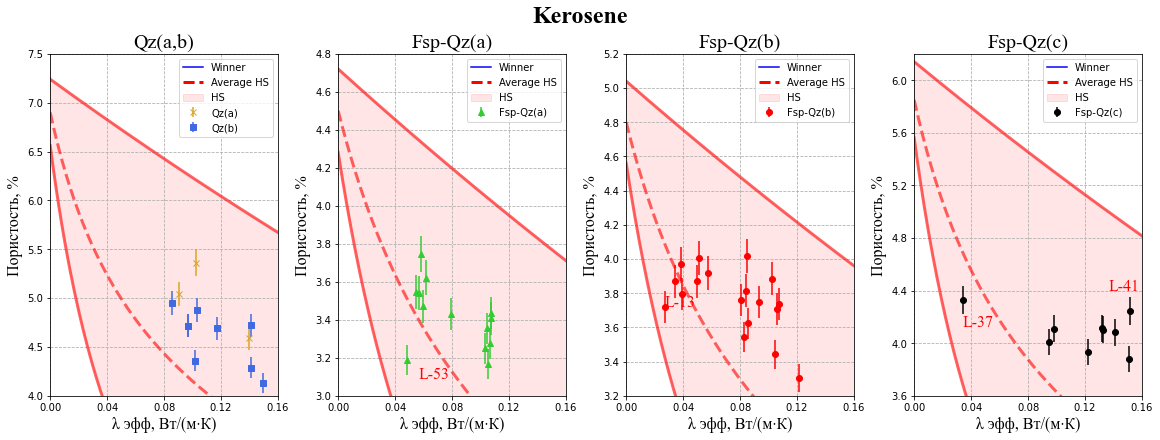

In [ ]:
fig4 = plt.figure(layout='constrained', figsize=(16, 6))
axs = fig4.subplots(1, 4, sharex=True)

fluid_lam=0.13
# matrix_lam = [(3.03, fluid_lam), (3.45, fluid_lam), (3.97, fluid_lam)] # из уравнения регрессии
matrix_lam = [(0.01, fluid_lam), (0.01, fluid_lam), (0.01, fluid_lam), (0.01, fluid_lam)] # подобранные из границ ХШ


for ax, mlam in zip(axs, matrix_lam):

    tc_lich = []
    tc_wn_up, tc_wn_dw, tc_wn_mean = [], [], []
    tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []

    for i in porosity:
        conc = [1-i, i]
        tc_wn_up.append(upper_winner(conc, mlam))
        tc_wn_dw.append(lower_winner(conc, mlam))
        tc_wn_mean.append(Average_Winner(conc, mlam))

        tc_hs_up.append(Upper_Hashin_Strikman(conc, mlam))
        tc_hs_dw.append(Lower_Hashin_Strikman(conc, mlam))
        tc_hs_mean.append(Average_Hashin_Strikman(conc, mlam))

        tc_lich.append(Likhteneker(conc, mlam))

    # ax.set_title(f'linear_width={a0:.3g}')
    # ax.set_title(f'Porosity - λ ')
    ax.plot(porosity, tc_wn_up, c='blue')
    ax.plot(porosity, tc_wn_dw, c='blue', label='Winner')
    ax.plot(porosity, tc_hs_up, 'r-', lw=3, alpha=0.6)
    ax.plot(porosity, tc_hs_dw, 'r-', lw=3, alpha=0.6)
    ax.plot(porosity, tc_hs_mean, 'r--', lw=3, alpha=1, label='Average HS')
#     ax.plot(porosity, tc_wn_mean, 'b--', lw=3, alpha=1, label='Average Winner')
#     ax.plot(porosity,  tc_lich, 'w--', lw=3, alpha=1, label='Likhteneker')

    ax.fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1, label='HS')


    ax.set_xlabel('λ эфф, Вт/(м∙К)', fontsize=16, **csfont)
    ax.set_ylabel('Пористость, %', fontsize=16, **csfont)
    ax.grid(which='major', axis='both', linestyle='--')
    ax.set_xlim([0, 0.16])
    ax.set_xticks(np.arange(0, 0.17, 0.04), fontsize=20, **csfont)

# y1_value,y2_value  = 'λ water, W/(m·K)', 'λ kerosene, W/(m·K)'
x_value, y_value = 'Hydrostatic', 'λ kerosene, W/(m·K)'
error = 0.025 * df_qza[y_value]
axs[0].errorbar(df_qza[x_value]/100, df_qza[y_value], label='Qz(a)', color='Goldenrod', yerr=error, fmt='x')

error = 0.025 * df_qzb[y_value]
axs[0].errorbar(df_qzb[x_value]/100, df_qzb[y_value], label='Qz(b)',color='RoyalBlue', yerr=error, fmt='s')

tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []
# mlam = ([4.6, 4.40])
mlam = ([7.24, 6.56])
for i in porosity:
    conc = [1-i, i]

    tc_hs_up.append(Upper_Hashin_Strikman(conc, (mlam[0],fluid_lam)))
    tc_hs_dw.append(Lower_Hashin_Strikman(conc, (mlam[1], fluid_lam)))
    tc_hs_mean.append(Average_Hashin_Strikman(conc, ((mlam[0]+mlam[1])*0.5, fluid_lam)))

axs[0].plot(porosity, tc_hs_up, 'r-', lw=3, alpha=0.6)
axs[0].plot(porosity, tc_hs_dw, 'r-', lw=3, alpha=0.6)
axs[0].plot(porosity, tc_hs_mean, 'r--', lw=3, alpha=0.6)
axs[0].fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1)

axs[0].set_ylim([4, 7])
axs[0].set_yticks(np.arange(4, 7.6, 0.5), fontsize=20, **csfont)
axs[0].legend(loc='best', fontsize='medium')
axs[0].set_title(f'Qz(a,b)', fontsize=20, **csfont)


# plot2
error = 0.025 * df_fspqz1[y_value]
axs[1].errorbar(df_fspqz1[x_value]/100, df_fspqz1[y_value], label='Fsp-Qz(a)',color='Limegreen', yerr=error, fmt='^')

tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []
# mlam = ([4.6, 4.40])
mlam = ([4.72, 4.28])
for i in porosity:
    conc = [1-i, i]

    tc_hs_up.append(Upper_Hashin_Strikman(conc, (mlam[0],fluid_lam)))
    tc_hs_dw.append(Lower_Hashin_Strikman(conc, (mlam[1], fluid_lam)))
    tc_hs_mean.append(Average_Hashin_Strikman(conc, ((mlam[0]+mlam[1])*0.5, fluid_lam)))

axs[1].plot(porosity, tc_hs_up, 'r-', lw=3, alpha=0.6)
axs[1].plot(porosity, tc_hs_dw, 'r-', lw=3, alpha=0.6)
axs[1].plot(porosity, tc_hs_mean, 'r--', lw=3, alpha=0.6)
axs[1].fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1)

axs[1].set_ylim([3.0, 4.8])
axs[1].set_yticks(np.arange(3.0, 4.81, 0.2), fontsize=20, **csfont)
axs[1].legend(loc='best', fontsize='medium')
axs[1].set_title(f'Fsp-Qz(a)', fontsize=20, **csfont)

x_selected, y_selected = df_fspqz1[(df_fspqz1['Plug No.'].str.contains('L-53'))][x_value]/100, df_fspqz1[(df_fspqz1['Plug No.'].str.contains('L-53'))][y_value]
axs[1].annotate('L-53', xy=(x_selected+0.008, y_selected-0.1), fontsize=16, **csfont, color='red')




# tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []
# for i in porosity:
#     conc = [1-i, i]

#     tc_hs_up.append(Upper_Hashin_Strikman(conc, (4.73,fluid_lam)))
#     tc_hs_dw.append(Lower_Hashin_Strikman(conc, (4.37, fluid_lam)))
# axs[1].plot(porosity, tc_hs_up, 'r-', lw=3, alpha=0.6)
# axs[1].plot(porosity, tc_hs_dw, 'r-', lw=3, alpha=0.6)
# axs[1].fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1, label='HS')


#plot3

error = 0.025 * df_fspqz2[y_value]
axs[2].errorbar(df_fspqz2[x_value]/100, df_fspqz2[y_value], label='Fsp-Qz(b)',color='Red', yerr=error, fmt='o')

tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []
# mlam = ([5.1, 4.5])
mlam = ([5.04, 4.56])

for i in porosity:
    conc = [1-i, i]

    tc_hs_up.append(Upper_Hashin_Strikman(conc, (mlam[0],fluid_lam)))
    tc_hs_dw.append(Lower_Hashin_Strikman(conc, (mlam[1], fluid_lam)))
    tc_hs_mean.append(Average_Hashin_Strikman(conc, ((mlam[0]+mlam[1])*0.5, fluid_lam)))

axs[2].plot(porosity, tc_hs_up, 'r-', lw=3, alpha=0.6)
axs[2].plot(porosity, tc_hs_dw, 'r-', lw=3, alpha=0.6)
axs[2].plot(porosity, tc_hs_mean, 'r--', lw=3, alpha=0.6)
axs[2].fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1)

axs[2].set_ylim([3.2,5.2])
axs[2].set_yticks(np.arange(3.2, 5.3, 0.2), fontsize=20, **csfont)
axs[2].legend(loc='best', fontsize='medium')
axs[2].set_title(f'Fsp-Qz(b)', fontsize=20, **csfont)


x_selected, y_selected = df_fspqz2[(df_fspqz2['Plug No.'].str.contains('L-13'))][x_value]/100, df_fspqz2[(df_fspqz2['Plug No.'].str.contains('L-13'))][y_value]
axs[2].annotate('L-13', xy=(x_selected, y_selected), fontsize=16, **csfont, color='red')



# tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []
# for i in porosity:
#     conc = [1-i, i]

#     tc_hs_up.append(Upper_Hashin_Strikman(conc, (4.73,fluid_lam)))
#     tc_hs_dw.append(Lower_Hashin_Strikman(conc, (4.37, fluid_lam)))
# axs[1].plot(porosity, tc_hs_up, 'r-', lw=3, alpha=0.6)
# axs[1].plot(porosity, tc_hs_dw, 'r-', lw=3, alpha=0.6)
# axs[1].fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1, label='HS')

# plot4
error = 0.025 * df_fspqz3[y_value]
axs[3].errorbar(df_fspqz3[x_value]/100, df_fspqz3[y_value], label='Fsp-Qz(c)',color='Black', yerr=error, fmt='o')

axs[3].set_ylim([3.6, 6.2])
axs[3].set_yticks(np.arange(3.6, 6.3, 0.4), fontsize=20, **csfont)
axs[3].legend(loc='best', fontsize='medium')
axs[3].set_title(f'Fsp-Qz(c)', fontsize=20, **csfont)

tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []
# mlam = ([5.1, 4.5])
mlam = ([6.14, 5.56])

for i in porosity:
    conc = [1-i, i]

    tc_hs_up.append(Upper_Hashin_Strikman(conc, (mlam[0],fluid_lam)))
    tc_hs_dw.append(Lower_Hashin_Strikman(conc, (mlam[1], fluid_lam)))
    tc_hs_mean.append(Average_Hashin_Strikman(conc, ((mlam[0]+mlam[1])*0.5, fluid_lam)))

axs[3].plot(porosity, tc_hs_up, 'r-', lw=3, alpha=0.6)
axs[3].plot(porosity, tc_hs_dw, 'r-', lw=3, alpha=0.6)
axs[3].plot(porosity, tc_hs_mean, 'r--', lw=3, alpha=0.6)
axs[3].fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1)

x_selected, y_selected = df_fspqz3[(df_fspqz3['Plug No.'].str.contains('L-37'))][x_value]/100, df_fspqz3[(df_fspqz3['Plug No.'].str.contains('L-37'))][y_value]
axs[3].annotate('L-37', xy=(x_selected, y_selected-0.2), fontsize=16, **csfont, color='red')

x_selected, y_selected = df_fspqz3[(df_fspqz3['Plug No.'].str.contains('L-41'))][x_value]/100, df_fspqz3[(df_fspqz3['Plug No.'].str.contains('L-41'))][y_value]
axs[3].annotate('L-41', xy=(x_selected-0.015, y_selected+0.15), fontsize=16, **csfont, color='red')


fig4.suptitle(f'Kerosene', weight='bold', fontsize=24, **csfont)
plt.show()


## Диапазон измения λматрицы с погрегносью 5%

In [ ]:
lam_matrix = [6.90, 4.50, 4.80, 5.85]
error1 = (np.round(0.05*x+x, 2)  for x in lam_matrix )
error2 = (np.round(-0.05*x+x, 2)  for x in lam_matrix )
print(*error2)
print(*error1)

6.56 4.28 4.56 5.56
7.24 4.72 5.04 6.14


### Минеральная матрица
#### Теплопроводность минеральной матрицы для группы моноктовых песчаников Qz(a,b) использована одна для двух групп, определенная из уравнения регрессии "теплопроводность (высушенные) - пористость" (для воды и керосина значимых корреляций не выявлено), поскольку все эксперементальные данные лежали близко к средние границы ХШ. λм (Qz - a, b)=6.90Вт/(мК);

#### Для группы Fsp-Qz(a) и Fsp-Qz(b,c) использована разная матрица - теплопроводность матрицы для олигомиктовых, опредленная по средней границе ХШ. λматрица из уравнений регрессии для каждой из групп демонстрирет заниженные значения при расчете границ как Винера, так и ХШ (для отдельных образцов), что говорит о не физичности результата. Была определена через границы ХШ одна λм(Fsp-Qz(a))=5.00 Вт/(мК); λм(Fsp-Qz(b,c))=5.80 Вт/(мК)

![image.png](attachment:image.png)

## Изотропная модель ОСП для теплопроводности (двухкомпонентная = минеральная матрица + пустотное пространство)

In [ ]:
def effective_tc(conc, alpha_shape, lam):

    x0=0

    phi = conc

    #------------------depolarization factor calculation-----
    def depolarizaton(alpha):
        if alpha < 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(t2-1)
            t5 = np.arctan(t4)
            t8 = t4 ** 2
            form = t2 * (t4-t5) / t8 / t4
            return form
        elif alpha > 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(1-t2)
            t6 = np.log(1+t4)
            t9 = np.log(1-t4)
            t13 = t4 ** 2
            form = t2 * (t6 / 2-t9 / 2-t4) / t13 / t4
            return form
        elif alpha == 1:
            form = 1 / 3
            return form


    depolar_F = []
    for i in alpha_shape:
        depolar_F.append(depolarizaton(i))

    L0 = lam[0]

    def raschet(L0):

        parall_comp, perpen_comp = [], []
#         print('Тело сравнения', L0)

        for i, j, f in zip(phi, lam, depolar_F):

#             print('Каждая комопонента')
#             print(i, j, f)

            termc_3 = i * j / (L0 * (1-f)+j * f)
            termz_3 = i / (L0 * (1-f)+j * f)

            termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
            termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

            termc_all = (termc_3+2 * termc_12) / 3
            termz_all = (termz_3+2 * termz_12) / 3

            t16 = termc_all # числитель
            t15 = termz_all # Знаменатель

#             print('ТС матрицы', j)
#             print('t16:' , t16)
#             print('t15:' , t15)

            parall_comp.append(t16)  # числитель формулы (матрица, флюид)
            perpen_comp.append(t15)  # знаменатель формулы (матрица, флюид)

#         print('Параллельный компоненты ТС', parall_comp)
#         print('Перпендикулярные компоненты ТС', perpen_comp)

        L_eff = np.sum(parall_comp) / np.sum(perpen_comp)
#         print('TC eff: ', L_eff, end='\n\n')
        return L_eff

    x0 = L0
    L0 = raschet(x0)
    it_f = 1
    while abs(x0-L0) >= 10 **-6:
        x0 = L0
        L0 = raschet(x0)
        it_f += 1

#     print('Количество итераций: ', it_f, end='\n\n')
    return L0
#     print('Эффективное значение TC_eff:', raschet(L0))


## Планшет зависимости Теплороводности от Пористости при разном аспектном отношении (модель ОСП)

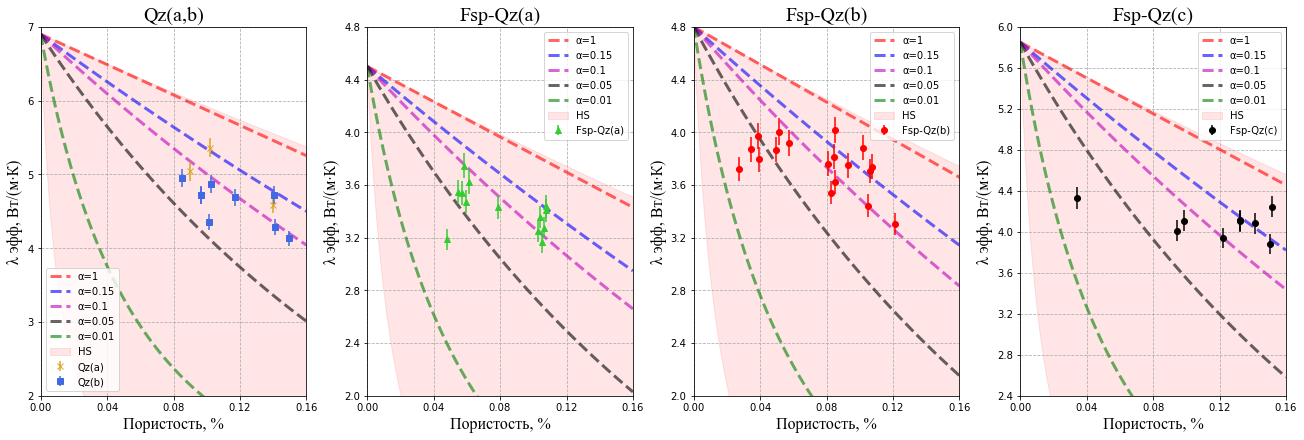

In [ ]:
fig5 = plt.figure(layout='constrained', figsize=(18, 6))
axs = fig5.subplots(1, 4, sharex=True)

fluid_lam=0.025
# matrix_lam = [(3.03, fluid_lam), (3.45, fluid_lam), (3.97, fluid_lam)] # из уравнения регрессии
matrix_lam = [(6.90, fluid_lam), (4.50, fluid_lam), (4.80, fluid_lam), (5.85, fluid_lam)] # подобранные из границ ХШ

for ax, mlam in zip(axs, matrix_lam):

    tc_eff_air2, tc_eff_water2, tc_eff_oil2, tc_002, tc_005= [], [], [], [], []
    por = np.linspace(0, 0.16, 100)

    alpha_shape = [1, 1]
    for i in por:
        conc = [1-i, i]
        tc_eff_air2.append(effective_tc(conc, alpha_shape, mlam))

    alpha_shape = [1, 0.15]
    for i in por:
        conc = [1-i, i]
        tc_eff_water2.append(effective_tc(conc, alpha_shape, mlam))


    alpha_shape = [1, 0.1]
    for i in por:
        conc = [1-i, i]
        tc_eff_oil2.append(effective_tc(conc, alpha_shape, mlam))

    alpha_shape = [1, 0.05]
    for i in por:
        conc = [1-i, i]
        tc_002.append(effective_tc(conc, alpha_shape, mlam))

    alpha_shape = [1, 0.01]
    for i in por:
        conc = [1-i, i]
        tc_005.append(effective_tc(conc, alpha_shape, mlam))



    tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []

    for i in porosity:
        conc = [1-i, i]

        tc_hs_up.append(Upper_Hashin_Strikman(conc, mlam))
        tc_hs_dw.append(Lower_Hashin_Strikman(conc, mlam))

    ax.plot(por, tc_eff_air2, 'r--', lw=3, alpha=0.6, label='α=1')
    ax.plot(por, tc_eff_water2, 'b--', lw=3, alpha=0.6, label='α=0.15')
    ax.plot(por, tc_eff_oil2, 'm--', lw=3, alpha=0.6, label='α=0.1')
    ax.plot(por, tc_002, 'k--', lw=3, alpha=0.6, label='α=0.05')
    ax.plot(por,  tc_005, 'g--', lw=3, alpha=0.6, label='α=0.01')


    ax.fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1, label='HS')

    ax.set_ylabel('λ эфф, Вт/(м∙К)', fontsize=16, **csfont)
    ax.set_xlabel('Пористость, %', fontsize=16, **csfont)
    ax.grid(which='major', axis='both', linestyle='--')
    ax.set_xlim([0, 0.16])
    ax.set_xticks(np.arange(0, 0.17, 0.04), fontsize=20, **csfont)

# plot1
error = 0.025 * df_qza[y_value]
axs[0].errorbar(df_qza[x_value]/100, df_qza[y_value], label='Qz(a)', color='Goldenrod', yerr=error, fmt='x')

error = 0.025 * df_qzb[y_value]
axs[0].errorbar(df_qzb[x_value]/100, df_qzb[y_value], label='Qz(b)',color='RoyalBlue', yerr=error, fmt='s')

axs[0].set_ylim([2, 7])
axs[0].set_yticks(np.arange(2, 7.1, 1), fontsize=20, **csfont)
axs[0].legend(loc='best', fontsize='medium')
axs[0].set_title(f'Qz(a,b)', fontsize=20, **csfont)


# plot2
axs[1].set_ylim([2, 4.8])
axs[1].set_yticks(np.arange(2, 4.9, 0.4), fontsize=20, **csfont)
axs[1].legend(loc='best', fontsize='medium')
axs[1].set_title(f'Fsp-Qz(a)', fontsize=20, **csfont)
error = 0.025 * df_fspqz1[y_value]
axs[1].errorbar(df_fspqz1[x_value]/100, df_fspqz1[y_value], label='Fsp-Qz(a)',color='Limegreen', yerr=error, fmt='^')

axs[1].legend(loc='best', fontsize='medium')

# plot2
axs[2].set_ylim([2, 4.8])
axs[2].set_yticks(np.arange(2, 4.9, 0.4), fontsize=20, **csfont)
axs[2].legend(loc='best', fontsize='medium')
axs[2].set_title(f'Fsp-Qz(b)', fontsize=20, **csfont)
error = 0.025 * df_fspqz2[y_value]
axs[2].errorbar(df_fspqz2[x_value]/100, df_fspqz2[y_value], label='Fsp-Qz(b)',color='Red', yerr=error, fmt='o')
axs[2].legend(loc='best', fontsize='medium')

# plot3
axs[3].set_ylim([2.4, 6])
axs[3].set_yticks(np.arange(2.4, 6.1, 0.4), fontsize=20, **csfont)
axs[3].legend(loc='best', fontsize='medium')
axs[3].set_title(f'Fsp-Qz(c)', fontsize=20, **csfont)
error = 0.025 * df_fspqz3[y_value]
axs[3].errorbar(df_fspqz3[x_value]/100, df_fspqz3[y_value], label='Fsp-Qz(c)',color='Black', yerr=error, fmt='o')
axs[3].legend(loc='best', fontsize='medium')

plt.show()

# Анализ определенно аспектного отношения

In [ ]:
path_to_ser = Path(r'/Users/maryiakalinina/Desktop/Индия_моделирование/Обратная_три флюида/INDIA_DATA_MODEL_edit.xlsx')
df_ues_ar = pd.read_excel(path_to_ser, sheet_name='Physical properties (2)', skiprows=3)
df_ues_ar.head()
df_ues_ar.tail(4)

,№,Well,Formation,Gross Lithology,Plug No.,Plug Depth (m),Diameter (mm),Length (mm),Weight (g),Porosity (%),...,"Average, %.4","RMS, %.4","Average, %.5","RMS, %.5","Average, %.6","RMS, %.6","Average, %.7","RMS, %.7","Average, %.8","RMS, %.8"
61,50.0,NaN,Dhrangadhra,Sandstone,L-51,2058.36,25.620001,26.629999,30.549999,15.191511,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaN,NaN,Samples were destroyed during measurements at ...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,NaN,NaN,NaN,NaN,NaN,Sample broke in half before starts of experime...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_ues_ar.drop([62, 63, 64]) # убрать строки с комментариями

,№,Well,Formation,Gross Lithology,Plug No.,Plug Depth (m),Diameter (mm),Length (mm),Weight (g),Porosity (%),...,"Average, %.4","RMS, %.4","Average, %.5","RMS, %.5","Average, %.6","RMS, %.6","Average, %.7","RMS, %.7","Average, %.8","RMS, %.8"
0,1.0,LODHIKA 1,Deccan trap,Weatherd basalt,L-1,279.73,25.530001,28.660000,37.650002,1.768120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,NaN,Deccan trap,Weatherd basalt,L-2,280.04,25.540001,26.000000,33.320000,2.787322,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,NaN,Deccan trap,Basalt,L-3,472.05,25.610001,26.740000,35.950001,2.662976,...,6.04,0.38,1.08,0.11,9.30,0.65,0.65,0.19,48.00,2.08
3,59.0,NaN,Dhrangadhra,Maroon Claystone,L-65,2667.3,25.620001,27.940001,39.400002,1.277368,...,3.99,2.20,0.44,0.07,4.55,0.40,0.48,0.09,53.73,1.63
4,9.0,NaN,Wadhawan,Sandstone,L-9,1387.7,25.650000,27.590000,34.799999,7.581984,...,7.41,1.04,0.77,0.67,0.88,0.30,0.46,0.11,53.68,0.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,46.0,NaN,Dhrangadhra,Sandstone,L-47,2057.41,25.670000,27.340000,33.340000,10.447529,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,47.0,NaN,Dhrangadhra,Sandstone,L-48,2057.54,25.620001,27.700001,32.910000,12.684872,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,48.0,NaN,Dhrangadhra,Sandstone,L-49,2057.95,25.610001,26.100000,30.299999,14.821300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,49.0,NaN,Dhrangadhra,Sandstone,L-50,2058.21,25.660000,26.700001,31.010000,14.661520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_ues_ar[["Hydrostatic","Aspect ratio (3 fluids)"]]

,Hydrostatic,Aspect ratio (3 fluids)
0,9.799979,NaN
1,12.346386,NaN
2,9.829516,NaN
3,1.772410,NaN
4,7.901107,0.040551
...,...,...
60,14.073974,0.071779
61,14.929217,0.058614
62,NaN,NaN
63,NaN,NaN


In [ ]:
df_ues_ar_drop=df_ues_ar.dropna(subset=["Hydrostatic","Aspect ratio (3 fluids)", "TC eff dry", "TC eff water",
                                        "TC eff kerosene"])

In [ ]:
df_ues_ar_drop[["Plug No.", "Hydrostatic","Aspect ratio (3 fluids)", "TC eff dry", "TC eff water",
                                        "TC eff kerosene"]]

,Plug No.,Hydrostatic,Aspect ratio (3 fluids),TC eff dry,TC eff water,TC eff kerosene
4,L-9,7.901107,0.040551,2.749054,3.915372,3.40912
5,L-12,6.151551,0.034356,2.908385,4.042409,3.584387
6,L-15,10.639758,0.055463,2.633232,3.829350,3.233864
7,L-16,10.755331,0.058614,2.653638,3.740994,3.240317
8,L-23,10.291772,0.051523,2.610351,3.761066,3.22997
9,L-24,10.532303,0.045290,2.475839,3.732277,3.14125
10,L-26,5.474529,0.024210,2.774103,3.986874,3.558015
11,L-27,5.940696,0.023768,2.664735,3.946700,3.474035
12,L-33,10.743890,0.064269,2.738496,3.841403,3.29924
14,L-35,10.430675,0.060814,2.731437,3.855873,3.303842


In [ ]:
x_val_ar, y_val_ar = df_ues_ar_drop["Hydrostatic"], df_ues_ar_drop["Aspect ratio (3 fluids)"]
print(max(y_val_ar))

0.089536


# Сross-plot Pore Aspect Ratio (inverse 3 fluids) - Porosity/Permeability

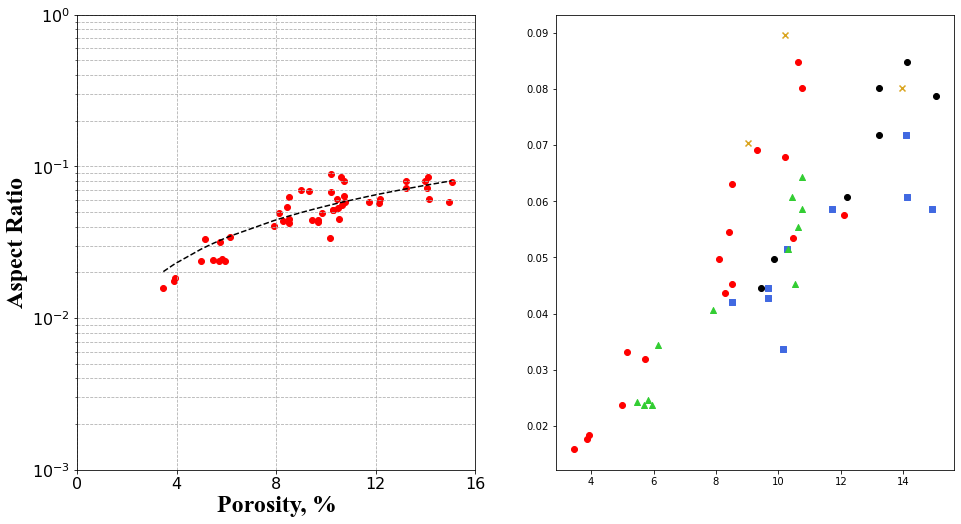

In [ ]:
# Initialise the subplot function using number of rows and columns
figure6, ax = plt.subplots(1, 2, figsize=(14, 8))
figure6.tight_layout(pad=5.0)


import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b):
    return a * x**b
#     return np.exp(a+b*x)
#     return a+b*np.log(x)

#plot1
sorted_df_ar = df_ues_ar_drop.sort_values(by='Hydrostatic') # df_andS - только песчаники
xdata_ar, ydata_ar = sorted_df_ar["Hydrostatic"], sorted_df_ar["Aspect ratio (3 fluids)"]
popt, pcov = curve_fit(func, xdata_ar, ydata_ar)
# print('Коэффициенты в уравнении', popt, pcov) # коэффициенты в уравнении
# print('Коэффициент корреляции', np.corrcoef(xdata_ar, ydata_ar)[0, 1])
from scipy.stats.stats import pearsonr
# print('Значимость по Пирсону (для линейной корреляции)', pearsonr(xdata_ar, ydata_ar))

# For Sine Function
ax[0].scatter(df_ues_ar_drop["Hydrostatic"], df_ues_ar_drop["Aspect ratio (3 fluids)"], label='AR', color='red')
ax[0].plot(xdata_ar, func(xdata_ar, *popt), 'k--')
# ax[0].plot(xdata_ar, func(xdata_ar, *popt), 'k--', label='AR =%5.5f· φ^%5.5f' % tuple(popt))
# ax[0].set_title("Porosity India - Aspect ratio", fontsize=20, **csfont)
# ax[0].annotate('R2=0,82', xy=(4, 0.15), fontsize=24, **csfont)
label_font_weight='bold'

ax[0].grid(which='both', axis='both', linestyle='--')
ax[0].set_xlabel('Porosity, %', fontsize=24, **csfont, fontweight =label_font_weight)
ax[0].set_ylabel('Aspect Ratio', fontsize=24, **csfont, fontweight =label_font_weight)


ax[0].set_yscale('log', base=10)
ax[0].set_xlim([0, 16])
ax[0].set_ylim([0.001, 1])
ax[0].set_xticks(np.arange(0, 17, 4), fontsize=20, **csfont)

ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)
# ax[0].legend(loc='best', fontsize=14)


#plot2

df_qza = df_ues_ar_drop[df_ues_ar_drop['Thermophysical group'] == 'Qz(a)']
df_qzb = df_ues_ar_drop[df_ues_ar_drop['Thermophysical group']=='Qz(b)']
df_fspqz1 = df_ues_ar_drop[df_ues_ar_drop['Thermophysical group']==('Fsp-Qz(a)')]
df_fspqz2 = df_ues_ar_drop[df_ues_ar_drop['Thermophysical group']==('Fsp-Qz(b)')]
df_fspqz3= df_ues_ar_drop[df_ues_ar_drop['Thermophysical group']==('Fsp-Qz(c)')]

ax[1].scatter(df_qza["Hydrostatic"], df_qza["Aspect ratio (3 fluids)"], label='Qz(a)', color='Goldenrod', marker='x')
ax[1].scatter(df_qzb["Hydrostatic"], df_qzb["Aspect ratio (3 fluids)"], label='Qz(b)',color='RoyalBlue', marker='s')
ax[1].scatter(df_fspqz1["Hydrostatic"], df_fspqz1["Aspect ratio (3 fluids)"], label='Fsp-Qz(a)',color='Limegreen', marker='^')
ax[1].scatter(df_fspqz2["Hydrostatic"], df_fspqz2["Aspect ratio (3 fluids)"], label='Fsp-Qz(b)',color='Red', marker='o')
ax[1].scatter(df_fspqz3["Hydrostatic"], df_fspqz3["Aspect ratio (3 fluids)"], label='Fsp-Qz(c)',color='Black', marker='o')


# # ax[1].plot(xdata_ar, func(xdata_ar, *popt), 'k--', label='AR =%5.5f· φ^%5.5f' % tuple(popt))
# ax[1].plot(xdata_ar, func(xdata_ar, *popt), 'k--')
# ax[1].set_title("Porosity India - Aspect ratio", fontsize=20, **csfont)
# # ax[1].annotate('R2=0,82', xy=(4, 0.15), fontsize=24, **csfont)
# ax[1].grid(which='both', axis='both', linestyle='--')
# ax[1].set_xlabel('Porosity, %', fontsize=16, **csfont)
# ax[1].set_ylabel('Aspect Ratio', fontsize=16, **csfont)
# ax[1].set_yscale('log', base=10)
# ax[1].set_xlim([0, 16])
# ax[1].set_ylim([0.001, 1])
# ax[1].set_xticks(np.arange(0, 17, 2), fontsize=20, **csfont)
# ax[1].legend(loc='best', fontsize=14)


# #plot3

# # For Sine Function
# ax[2].scatter(df_ues_ar_drop["K[He](mD)"], df_ues_ar_drop["Aspect ratio (3 fluids)"], label='AR', color='red')
# ax[2].set_title("Permeability - Aspect ratio", fontsize=20, **csfont)
# ax[2].grid(which='both', axis='both', linestyle='--')
# ax[2].set_xlabel('K[He](mD), %', fontsize=16, **csfont)
# ax[2].set_ylabel('Aspect Ratio', fontsize=16, **csfont)
# ax[2].set_xscale('log', base=10)
# ax[2].set_yscale('log', base=10)
# ax[2].set_xlim([0.01, 10])
# ax[2].set_ylim([0.001, 1])
# # ax[2].set_xticks(np.arange(0, 17, 2), fontsize=20, **csfont)
# ax[2].legend(loc='best', fontsize=14)


plt.show()

In [ ]:
ε = (3*df_ues_ar_drop["Hydrostatic"]/100)/(4*pi*df_ues_ar_drop["Aspect ratio (3 fluids)"]) #плотность трещин

# Сross-plot Pore Aspect Ratio - Depth

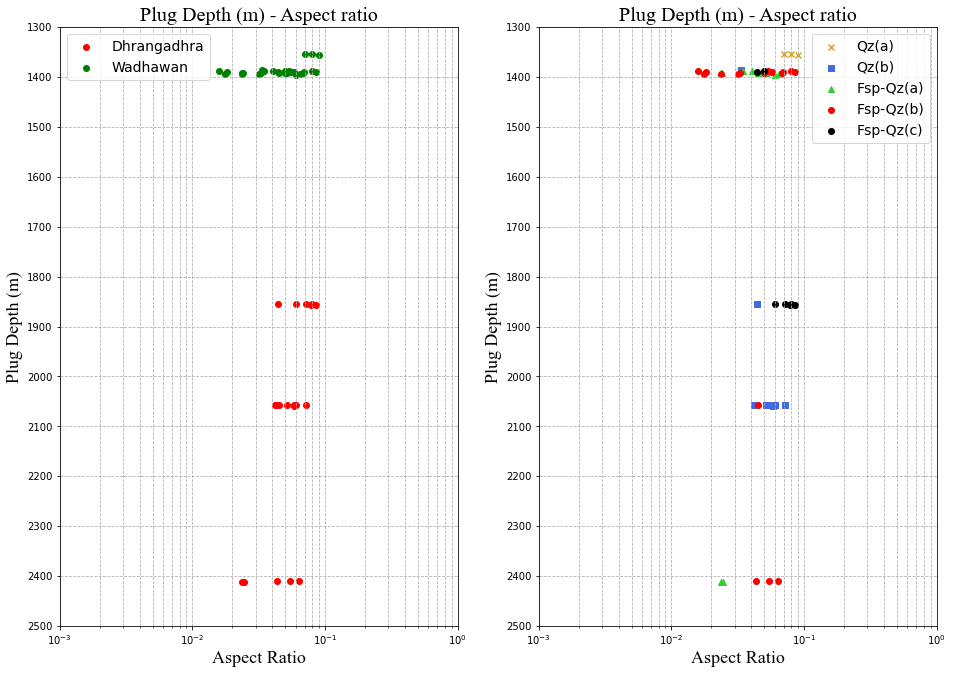

In [ ]:
# Initialise the subplot function using number of rows and columns
figure6, ax = plt.subplots(1, 2, figsize=(14, 10))
figure6.tight_layout(pad=5.0)

#plot1
df_wadh = df_ues_ar_drop[df_ues_ar_drop['Formation'] == 'Wadhawan']
df_dhra = df_ues_ar_drop[df_ues_ar_drop['Formation']=='Dhrangadhra']

ax[0].scatter(df_dhra["Aspect ratio (3 fluids)"], df_dhra["Plug Depth (m)"], label='Dhrangadhra', color='red')
ax[0].scatter(df_wadh["Aspect ratio (3 fluids)"], df_wadh["Plug Depth (m)"], label='Wadhawan', color='green')
ax[0].set_title("Plug Depth (m) - Aspect ratio", fontsize=20, **csfont)
# ax[0].annotate('R2=0,82', xy=(4, 0.15), fontsize=24, **csfont)

ax[0].grid(which='both', axis='both', linestyle='--')
ax[0].set_xlabel('Aspect Ratio', fontsize=18, **csfont)
ax[0].set_ylabel('Plug Depth (m)', fontsize=18, **csfont)
ax[0].set_xscale('log', base=10)
ax[0].set_xlim([0.001, 1])
ax[0].set_ylim([2500, 1300])
ax[0].set_yticks(np.arange(1300,2550, 100), fontsize=20, **csfont)
ax[0].legend(loc='best', fontsize=14)



df_qza = df_ues_ar_drop[df_ues_ar_drop['Thermophysical group'] == 'Qz(a)']
df_qzb = df_ues_ar_drop[df_ues_ar_drop['Thermophysical group']=='Qz(b)']
df_fspqz1 = df_ues_ar_drop[df_ues_ar_drop['Thermophysical group']==('Fsp-Qz(a)')]
df_fspqz2 = df_ues_ar_drop[df_ues_ar_drop['Thermophysical group']==('Fsp-Qz(b)')]
df_fspqz3= df_ues_ar_drop[df_ues_ar_drop['Thermophysical group']==('Fsp-Qz(c)')]

ax[1].scatter(df_qza["Aspect ratio (3 fluids)"], df_qza["Plug Depth (m)"], label='Qz(a)', color='Goldenrod', marker='x')
ax[1].scatter(df_qzb["Aspect ratio (3 fluids)"], df_qzb["Plug Depth (m)"], label='Qz(b)',color='RoyalBlue', marker='s')
ax[1].scatter(df_fspqz1["Aspect ratio (3 fluids)"], df_fspqz1["Plug Depth (m)"], label='Fsp-Qz(a)',color='Limegreen', marker='^')
ax[1].scatter(df_fspqz2["Aspect ratio (3 fluids)"], df_fspqz2["Plug Depth (m)"], label='Fsp-Qz(b)',color='Red', marker='o')
ax[1].scatter(df_fspqz3["Aspect ratio (3 fluids)"], df_fspqz3["Plug Depth (m)"], label='Fsp-Qz(c)',color='Black', marker='o')

ax[1].grid(which='both', axis='both', linestyle='--')
ax[1].set_xlabel('Aspect Ratio', fontsize=18, **csfont)
ax[1].set_ylabel('Plug Depth (m)', fontsize=18, **csfont)
ax[1].set_xscale('log', base=10)
ax[1].set_xlim([0.001, 1])
ax[1].set_ylim([2500, 1300])
ax[1].set_yticks(np.arange(1300,2550, 100), fontsize=20, **csfont)
ax[1].set_title("Plug Depth (m) - Aspect ratio", fontsize=20, **csfont)
ax[1].legend(loc='best', fontsize=14)



plt.show()

## Cross plot Measured λ - Predicted λ

In [ ]:
x_dry, y_dry = df_ues_ar_drop["λ dry, W/(m·K)"], df_ues_ar_drop["TC eff dry"]
x_water, y_water = df_ues_ar_drop["λ water, W/(m·K)"], df_ues_ar_drop["TC eff water"]
x_kerosene, y_kerosene = df_ues_ar_drop["λ kerosene, W/(m·K)"], df_ues_ar_drop["TC eff kerosene"]

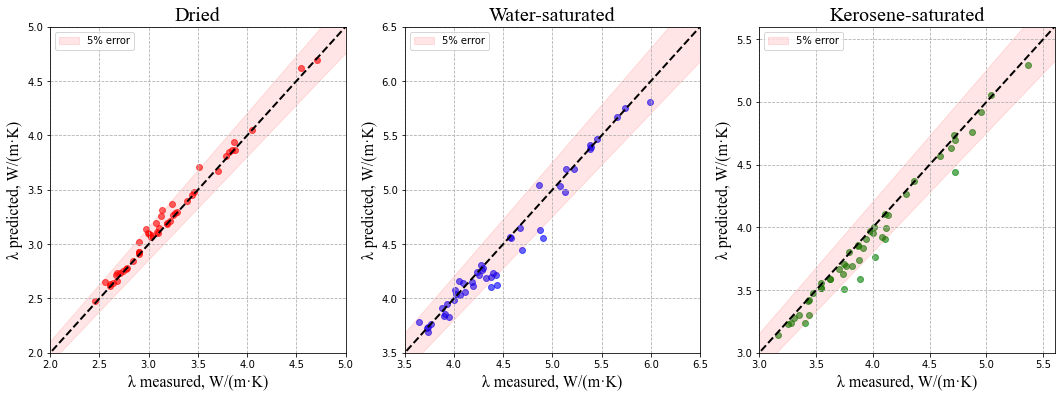

In [ ]:
fig10, axs = plt.subplots(1, 3, figsize=(18, 6))
figure.tight_layout(pad=5.0)

dots = np.linspace(0, 7, 100)
dots_up = [i+i*0.05 for i in dots]
dots_dw = [i-i*0.05 for i in dots]

#plot1
axs[0].plot(dots, dots, "k--",  linewidth=2)
axs[0].fill_between(dots, dots_up, dots_dw, color='r', alpha=.1, label='5% error')
axs[0].scatter(x_dry, y_dry,color='Red', marker='o',  alpha=0.6)
axs[0].set_title(f'Dried', fontsize=20, **csfont)
axs[0].grid(which='both', axis='both', linestyle='--')

axs[0].set_xlabel('λ measured, W/(m·K)', fontsize=16, **csfont)
axs[0].set_ylabel('λ predicted, W/(m·K)', fontsize=16, **csfont)

axs[0].set_ylim([2, 5])
axs[0].set_xlim([2, 5])
axs[0].set_xticks(np.arange(2, 5.1, 0.5), fontsize=20, **csfont)
axs[0].set_yticks(np.arange(2, 5.1, 0.5), fontsize=20, **csfont)
axs[0].legend(loc='best', fontsize='medium')


#plot2
axs[1].scatter(x_water, y_water ,color='Blue', marker='o',  alpha=0.6)
axs[1].grid(which='both', axis='both', linestyle='--')
axs[1].set_title(f'Water-saturated', fontsize=20, **csfont)
axs[1].set_xlim([3.5, 6.5])
axs[1].set_ylim([3.5, 6.5])
axs[1].set_xticks(np.arange(3.5, 6.6, 0.5), fontsize=20, **csfont)
axs[1].set_yticks(np.arange(3.5, 6.6, 0.5), fontsize=20, **csfont)
axs[1].plot(dots, dots, "k--",  linewidth=2)
axs[1].fill_between(dots, dots_up, dots_dw, color='r', alpha=.1, label='5% error')
axs[1].legend(loc='best', fontsize='medium')
axs[1].set_xlabel('λ measured, W/(m·K)', fontsize=16, **csfont)
axs[1].set_ylabel('λ predicted, W/(m·K)', fontsize=16, **csfont)

#plot2
axs[2].scatter(x_kerosene, y_kerosene ,color='Green', marker='o', alpha=0.6)
axs[2].set_title(f'Kerosene-saturated', fontsize=20, **csfont)
axs[2].set_ylim([3, 5.6])
axs[2].set_xlim([3, 5.6])
axs[2].set_xticks(np.arange(3, 5.6, 0.5), fontsize=20, **csfont)
axs[2].set_yticks(np.arange(3, 5.6, 0.5), fontsize=20, **csfont)
axs[2].grid(which='both', axis='both', linestyle='--')
axs[2].plot(dots, dots, "k--",  linewidth=2)
axs[2].fill_between(dots, dots_up, dots_dw, color='r', alpha=.1, label='5% error')
axs[2].legend(loc='best', fontsize='medium')
axs[2].set_xlabel('λ measured, W/(m·K)', fontsize=16, **csfont)
axs[2].set_ylabel('λ predicted, W/(m·K)', fontsize=16, **csfont)

plt.show()

# Parametric study

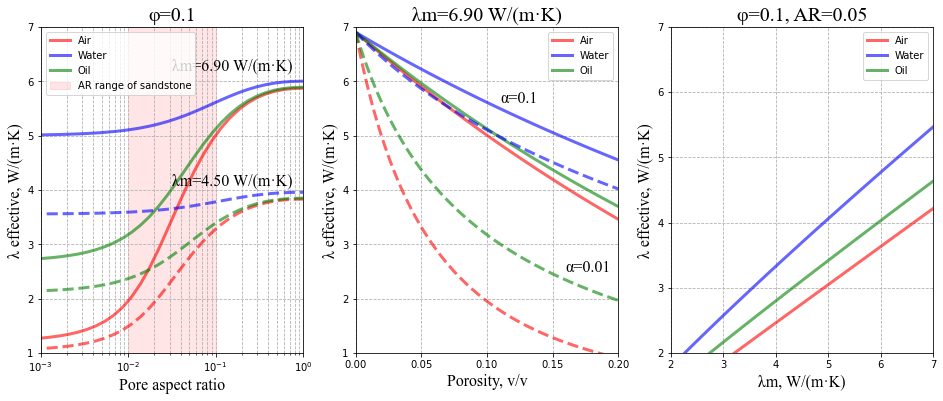

In [ ]:
csfont = {'fontname':'Times New Roman'}
fig11, axs = plt.subplots(1, 3, figsize=(16, 6))
# figure.tight_layout(pad=5.0)

#plot1 - Distribution of thermsal conductivity as a function of pore aspect ration f
#or dry, water- and kerodene saturated rock (with λm=6.90 and 4.50 W/(m·K), φ=0.1 )

conc = [0.9, 0.1]
λm1, λm2 = 6.90, 4.50 # максимальное и минимальное значение теплопрвоодности матрицы, определенное по границам ХШ

a_pore = np.logspace(-4, 1, num=50, base=10)
tc_eff_air1, tc_eff_water1, tc_eff_oil1 = [], [], []
tc_eff_air2, tc_eff_water2, tc_eff_oil2 = [], [], []

# Set1
lam = [λm1, 0.025]
for i in a_pore:
    alpha_shape = [1, i]
    tc_eff_air1.append(effective_tc(conc, alpha_shape, lam))

lam = [λm1, 0.6]
for i in a_pore:
    alpha_shape = [1, i]
    tc_eff_water1.append(effective_tc(conc, alpha_shape, lam))

lam = [λm1, 0.1]
for i in a_pore:
    alpha_shape = [1, i]
    tc_eff_oil1.append(effective_tc(conc, alpha_shape, lam))

# Set2
lam = [λm2, 0.025]
for i in a_pore:
    alpha_shape = [1, i]
    tc_eff_air2.append(effective_tc(conc, alpha_shape, lam))

lam = [λm2, 0.6]
for i in a_pore:
    alpha_shape = [1, i]
    tc_eff_water2.append(effective_tc(conc, alpha_shape, lam))

lam = [λm2, 0.1]
for i in a_pore:
    alpha_shape = [1, i]
    tc_eff_oil2.append(effective_tc(conc, alpha_shape, lam))
#λm1
axs[0].plot(a_pore, tc_eff_air1, 'r-', lw=3, alpha=0.6, label='Air')
axs[0].plot(a_pore, tc_eff_water1, 'b-', lw=3, alpha=0.6, label='Water')
axs[0].plot(a_pore, tc_eff_oil1, 'g-', lw=3, alpha=0.6, label='Oil')

#λm2
axs[0].plot(a_pore, tc_eff_air2, 'r--', lw=3, alpha=0.6)
axs[0].plot(a_pore, tc_eff_water2, 'b--', lw=3, alpha=0.6)
axs[0].plot(a_pore, tc_eff_oil2, 'g--', lw=3, alpha=0.6)

dots = np.linspace(1, 7, 100)
dots_up = 10**-2
dots_dw = 10**-1
axs[0].fill_betweenx(dots, dots_up, dots_dw, color='r', alpha=.1, label='AR range of sandstone')

axs[0].grid(which='both', axis='both', linestyle='--')
axs[0].set_ylabel('λ effective, W/(m·K)', fontsize=16, **csfont)
axs[0].set_xlabel('Pore aspect ratio', fontsize=16, **csfont)
axs[0].set_xscale('log', base=10)
axs[0].set_ylim([1, 7])
axs[0].set_xlim([10**-3, 10**0])
# axs[0].set_xticks(np.arange(2, 5.1, 0.5), fontsize=20, **csfont)
axs[0].set_yticks(np.arange(1, 7.1, 1), fontsize=20, **csfont)
axs[0].legend(loc='best', fontsize='medium')
axs[0].annotate('λm=6.90 W/(m·K)', xy=(10**-1.5, 6.2), fontsize=16, **csfont, color='black')
axs[0].annotate('λm=4.50 W/(m·K)', xy=(10**-1.5, 4.1), fontsize=16, **csfont, color='black')
# axs[0].annotate('φ=0.1', xy=(10**0.2, 2), fontsize=24, **csfont, color='black', weight='bold')
axs[0].set_title(f'φ=0.1', fontsize=20, **csfont)


#plot12 - Distribution of thermal conductivity as a function of total porosity
#for dry, water- and kerodene saturated rock for diffrent aspect ratios (α=0.1, 0.01)
#(with λm=6.90)

λm = 6.90
conc_pore = np.linspace(0, 0.20, 100)
a_pore = 10**-1
tc_eff_air, tc_eff_water, tc_eff_oil = [], [], []

lam = [λm, 0.025]
for i in conc_pore:
    alpha_shape = [1, a_pore]
    conc=[1-i, i]

    tc_eff_air.append(effective_tc(conc, alpha_shape, lam))

lam = [λm, 0.6]
for i in conc_pore:
    alpha_shape = [1, a_pore]
    conc=[1-i, i]
    tc_eff_water.append(effective_tc(conc, alpha_shape, lam))

lam = [λm, 0.1]
for i in conc_pore:
    alpha_shape = [1, a_pore]
    conc=[1-i, i]
    tc_eff_oil.append(effective_tc(conc, alpha_shape, lam))

#---------
λm = 6.90
conc_pore = np.linspace(0, 0.20, 100)
a_pore = 10**-2
# a_pore = np.logspace(-4, 1, num=50, base=10)
tc_eff_air2, tc_eff_water2, tc_eff_oil2 = [], [], []

lam = [λm, 0.025]
for i in conc_pore:
    alpha_shape = [1, a_pore]
    conc=[1-i, i]
    tc_eff_air2.append(effective_tc(conc, alpha_shape, lam))

lam = [λm, 0.6]
for i in conc_pore:
    alpha_shape = [1, a_pore]
    conc=[1-i, i]
    tc_eff_water2.append(effective_tc(conc, alpha_shape, lam))

lam = [λm, 0.1]
for i in conc_pore:
    alpha_shape = [1, a_pore]
    conc=[1-i, i]
    tc_eff_oil2.append(effective_tc(conc, alpha_shape, lam))

axs[1].plot(conc_pore, tc_eff_air, 'r-', lw=3, alpha=0.6, label='Air')
axs[1].plot(conc_pore, tc_eff_water, 'b-', lw=3, alpha=0.6, label='Water')
axs[1].plot(conc_pore, tc_eff_oil, 'g-', lw=3, alpha=0.6, label='Oil')
axs[1].plot(conc_pore, tc_eff_air2, 'r--', lw=3, alpha=0.6)
axs[1].plot(conc_pore, tc_eff_water2, 'b--', lw=3, alpha=0.6)
axs[1].plot(conc_pore, tc_eff_oil2, 'g--', lw=3, alpha=0.6)
axs[1].grid(which='both', axis='both', linestyle='--')
axs[1].set_ylim([1, 7])
axs[1].set_xlim([0, 0.2])
axs[1].set_xticks(np.arange(0, 0.21, 0.05), fontsize=20, **csfont)
axs[1].set_yticks(np.arange(1, 7.1, 1), fontsize=20, **csfont)
axs[1].legend(loc='best', fontsize='medium')
axs[1].set_xlabel('Porosity, v/v', fontsize=16, **csfont)
axs[1].set_ylabel('λ effective, W/(m·K)', fontsize=16, **csfont)
axs[1].annotate('α=0.1', xy=(0.11, 5.6), fontsize=16, **csfont, color='black')
axs[1].annotate('α=0.01', xy=(0.16, 2.5), fontsize=16, **csfont, color='black')
# axs[0].annotate('φ=0.1', xy=(10**0.2, 2), fontsize=24, **csfont, color='black', weight='bol
axs[1].set_title(f'λm=6.90 W/(m·K)', fontsize=20, **csfont)


#plot3 - Distribution of mineral matrix thermsal conductivity as a function of pore aspect ration f
#or dry, water- and kerodene saturated rock (with AR=0.05, φ=0.1 )

conc = [0.9, 0.1]
a_pore = 0.05

λm1 = np.linspace(2, 7, num=100)
tc_eff_air1, tc_eff_water1, tc_eff_oil1 = [], [], []
tc_eff_air2, tc_eff_water2, tc_eff_oil2 = [], [], []

# Set1

for i in λm1:
    lam = [i, 0.025]
    alpha_shape = [1, a_pore]
    tc_eff_air1.append(effective_tc(conc, alpha_shape, lam))


for i in λm1:
    lam = [i, 0.60]
    alpha_shape = [1, a_pore]
    tc_eff_water1.append(effective_tc(conc, alpha_shape, lam))


for i in λm1:
    lam = [i, 0.13]
    alpha_shape = [1, a_pore]
    tc_eff_oil1.append(effective_tc(conc, alpha_shape, lam))


#λm1
axs[2].plot(λm1, tc_eff_air1, 'r-', lw=3, alpha=0.6, label='Air')
axs[2].plot(λm1, tc_eff_water1, 'b-', lw=3, alpha=0.6, label='Water')
axs[2].plot(λm1, tc_eff_oil1, 'g-', lw=3, alpha=0.6, label='Oil')


axs[2].grid(which='both', axis='both', linestyle='--')
axs[2].set_ylabel('λ effective, W/(m·K)', fontsize=16, **csfont)
axs[2].set_xlabel('λm, W/(m·K)', fontsize=16, **csfont)
axs[2].set_ylim([2, 7])
axs[2].set_xlim([2, 7])
# axs[0].set_xticks(np.arange(2, 5.1, 0.5), fontsize=20, **csfont)
axs[2].set_yticks(np.arange(2, 7.1, 1), fontsize=20, **csfont)
axs[2].legend(loc='best', fontsize='medium')
axs[2].annotate('λm=6.90 W/(m·K)', xy=(10**-0.9, 6.2), fontsize=16, **csfont, color='black')
# axs[0].annotate('φ=0.1', xy=(10**0.2, 2), fontsize=24, **csfont, color='black', weight='bold')
axs[2].set_title(f'φ=0.1, AR=0.05', fontsize=20, **csfont)

plt.show()

## Зависимость эффетивной теплопроводности теоретической модели ОСП от аспектного отношения пор/трещин и теплопроводности минеральной матрицы. Пористость = 10%

In [ ]:
# Код для построения 3d графико. alpha_shape = одно значение АО пор, lam_matrix = одно значение ТС матрицы
# Код упрощался специально под построение графика, так как невозможно использовать meshgrid с вложенным массивами
# как это было в исходном коде

def effective_tc_3d_new(alpha_shape, lam_matrix):

    conc1, conc2  = 0.8, 0.2 # conc1=объемная доля твердой части, conc2=пористость
    lam_fl = 0.44 # теплопроводность флюида
    dep_matr = 1/3 # коэффициент деполяризации твердой части

    #------------------depolarization factor calculation-----
    def depolarizaton(alpha):
        if alpha < 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(t2-1)
            t5 = np.arctan(t4)
            t8 = t4 ** 2
            form = t2 * (t4-t5) / t8 / t4
            return form
        elif alpha > 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(1-t2)
            t6 = np.log(1+t4)
            t9 = np.log(1-t4)
            t13 = t4 ** 2
            form = t2 * (t6 / 2-t9 / 2-t4) / t13 / t4
            return form
        elif alpha == 1:
            form = 1 / 3
            return form

    depolar_F = depolarizaton(alpha_shape)


    L0 = lam_matrix

    def raschet(L0):

        #matrix

        termc_3a = conc1 * lam_matrix / (L0 * (1-dep_matr)+lam_matrix * dep_matr)
        termz_3a = conc1 / (L0 * (1-dep_matr)+lam_matrix * dep_matr)

        termc_12a = conc1 * lam_matrix / (L0 * (1+dep_matr) / 2+lam_matrix * (1-dep_matr) / 2)
        termz_12a = conc1 / (L0 * (1+dep_matr) / 2+lam_matrix * (1-dep_matr) / 2)

#         print(termc_3a, termz_3a, termc_12a, termz_12a)


        #fluid
        termc_3b = conc2 * lam_fl / (L0 * (1-depolar_F)+lam_fl * depolar_F)
        termz_3b = conc2 / (L0 * (1-depolar_F)+lam_fl * depolar_F)

        termc_12b = conc2 * lam_fl / (L0 * (1+depolar_F) / 2+lam_fl * (1-depolar_F) / 2)
        termz_12b = conc2 / (L0 * (1+depolar_F) / 2+lam_fl * (1-depolar_F) / 2)

#         print("b", termc_3b, termz_3b, termc_12b, termz_12b)


        termc_all = (termc_3a+2 * termc_12a)/3 + (termc_3b+2 * termc_12b)/3
        termz_all = (termz_3a+2 * termz_12a)/3 + (termz_3b+2 * termz_12b)/3

#         print(termc_all / termz_all)
        return termc_all / termz_all

    x0 = L0
    L0 = raschet(x0)
    it_f = 1
    while abs(x0-L0) >= 10 **-6:
        x0 = L0
        L0 = raschet(x0)
        it_f += 1
    return L0


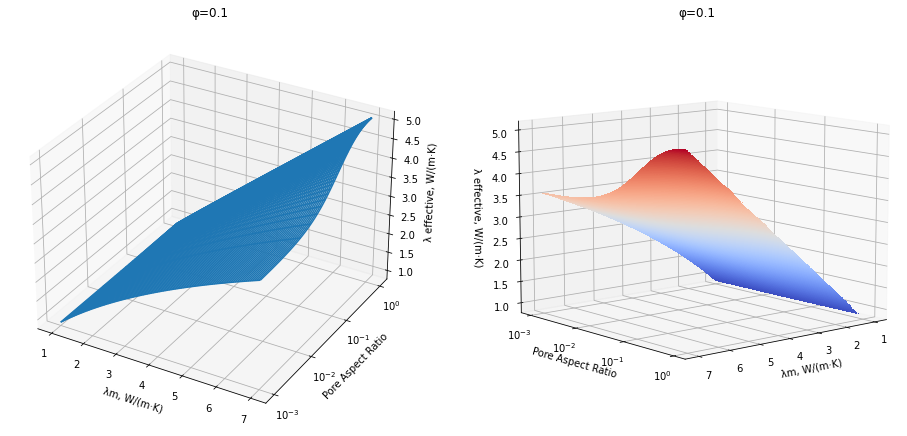

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import numpy as np
from matplotlib import cm
import matplotlib.ticker as mticker

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(121,projection="3d")

# Data set preparation
x = np.linspace(1, 7, 1000) # диапазон изменения ТС минеральной матрицы
y = np.logspace(-3, 0, num=1000, base=10) # диапазон изменения Аспектного отношения


x1 = np.linspace(x.min(), x.max(), len(x))
y1 = np.linspace(y.min(), y.max(), len(y))

"""
x, y via meshgrid for vectorized evaluation of
2 scalar/vector fields over 2-D grids, given
one-dimensional coordinate arrays x1, x2,..., xn.
"""

X,Y = x1, y1
X, Y = np.meshgrid(X, Y, indexing="ij")


Z = np.empty([len(x), len(x)])
for i in np.arange(len(x)):
    for j in np.arange(len(y)):
#         print('value', i,j, X[i][j], Y[i][j])
#         print(effective_tc_3d_new(Y[i][j], X[i][j]))
        Z[i][j] = effective_tc_3d_new(Y[i][j], X[i][j])


# Plot construsction
ax1.plot_wireframe(X, np.log10(Y), Z, rstride=10, cstride=10)
ax1.set(title='φ=0.1')
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax1.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax1.set_xlabel('λm, W/(m·K)')
ax1.set_ylabel('Pore Aspect Ratio')
ax1.set_zlabel('λ effective, W/(m·K)')


def log_tick_formatter(val, pos=None):
    return f"$10^{{{int(val)}}}$"

ax2 = fig.add_subplot(122,projection="3d")
# You still have to take log10(Z) but thats just one operation
# ax2.plot_trisurf(X, np.log10(Y), Z, linewidth=0.2, antialiased=True)
ax2.plot_surface(X, np.log10(Y), Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax2.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax2.set(title="φ=0.1")
ax2.set_xlabel('λm, W/(m·K)')
ax2.set_ylabel('Pore Aspect Ratio')
ax2.set_zlabel('λ effective, W/(m·K)')

# ax2.view_init(20, 180)
ax2.view_init(10, 50)

# plt.savefig("LinearLog.png", bbox_inches='tight')
plt.show()

## нет зависимости λm и аспектным отношением для модели ОСП. В статье Hartman показал зависимость между λm и аспектным отношением: АО уменьшеает с ростом λm
![%D0%A1%D0%BD%D0%B8%D0%BC%D0%BE%D0%BA%20%D1%8D%D0%BA%D1%80%D0%B0%D0%BD%D0%B0%202023-08-29%20%D0%B2%2017.30.25.png](attachment:%D0%A1%D0%BD%D0%B8%D0%BC%D0%BE%D0%BA%20%D1%8D%D0%BA%D1%80%D0%B0%D0%BD%D0%B0%202023-08-29%20%D0%B2%2017.30.25.png) https://arxiv.org/pdf/0806.2399.pdf

In [ ]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
path_to_ser = Path(r'/Users/maryiakalinina/Desktop/INDIA_DATA.xlsx')
df_ues = pd.read_excel(path_to_ser, sheet_name='Physical properties', skiprows=3)
df_ues.head()
df_ues.tail(4)
df_ues=df_ues.drop([62, 63, 64]) # убрать строки с комментариями


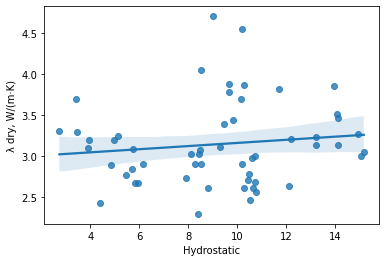

In [ ]:
df_andS = df_ues[(df_ues['Thermophysical group'] != 'Clay') & (df_ues['Thermophysical group'] != 'Gabbro') & (df_ues['Thermophysical group'] != 'Basalt')]
x_val_sandstone, y_val_sandstone = df_andS["Hydrostatic"], df_andS["λ dry, W/(m·K)"]

x = df_andS["Hydrostatic"]
y=df_andS["λ dry, W/(m·K)"]
sns.regplot(x, y, data =df_andS, x='Porosity', y='λ, W/(m·K) ')

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

<AxesSubplot:xlabel='λ dry, W/(m·K)', ylabel='Density'>

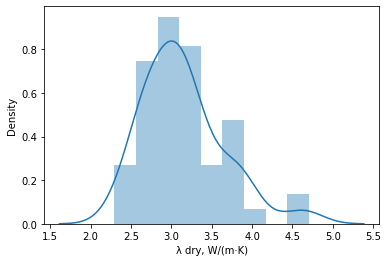

In [ ]:
sns.distplot(y)

# Расчет динамисческих модулей

![image.png](attachment:image.png)https://www.researchgate.net/profile/Per-Avseth/publication/265785721/figure/fig4/AS:667836242472960@1536235976068/Rock-physics-diagnostics-implies-the-use-of-rock-physics-models-to-predict-rock-texture_W640.jpg

![%D0%A1%D0%BD%D0%B8%D0%BC%D0%BE%D0%BA%20%D1%8D%D0%BA%D1%80%D0%B0%D0%BD%D0%B0%202023-09-21%20%D0%B2%2016.09.02.png](attachment:%D0%A1%D0%BD%D0%B8%D0%BC%D0%BE%D0%BA%20%D1%8D%D0%BA%D1%80%D0%B0%D0%BD%D0%B0%202023-09-21%20%D0%B2%2016.09.02.png)Снимок экрана 2023-09-21 в 16.09.02

In [ ]:
df_ues.iloc[:, :30]

,№,Well,Formation,Gross Lithology,Plug No.,Plug Depth (m),Diameter (mm),Length (mm),Weight (g),Porosity (%),...,Thermophysical group,Unnamed: 21,"ρbulk, g/cm3","λ dry, W/(m·K)","λ⊥, W/(m·K)",β1 (top surface),β2 (bottom surface),"C, MJ/(m3·K)",K,"λmax, W/(m·K)"
0,1.0,LODHIKA 1,Deccan trap,Weatherd basalt,L-1,279.73,25.530001,28.660000,37.650002,1.768120,...,Basalt,NaN,2.510713,1.511033,1.474428,0.062283,0.054933,2.061900,1.024849,1.511097
1,2.0,NaN,Deccan trap,Weatherd basalt,L-2,280.04,25.540001,26.000000,33.320000,2.787322,...,Basalt,NaN,2.455987,1.356650,1.412331,0.156617,0.110667,2.057483,0.961014,NaN
2,3.0,NaN,Deccan trap,Basalt,L-3,472.05,25.610001,26.740000,35.950001,2.662976,...,Basalt,NaN,2.614798,1.353500,1.300987,0.052117,0.064100,2.171683,1.040459,NaN
3,4.0,NaN,Wadhawan,Sandstone,L-4,1354.78,25.730000,28.469999,32.560001,14.399308,...,Qz(a),NaN,2.266679,3.847700,3.390266,0.068233,0.052350,1.780333,1.143906,NaN
4,5.0,NaN,Wadhawan,Sandstone,L-5,1355.15,25.600000,27.780001,33.540001,10.993021,...,Qz(a),NaN,2.381238,4.551342,3.961530,0.080267,0.087192,1.851583,1.148903,4.684882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,58.0,NaN,Dhrangadhra,Ferruginised Sandy Siltstone,L-62,2412.10,25.650000,27.910000,37.049999,4.226965,...,Fsp-Qz(a),NaN,2.575999,2.836867,2.298582,0.106533,0.056958,2.014567,1.235355,2.837895
58,59.0,NaN,Dhrangadhra,Maroon Claystone,L-65,2667.30,25.620001,27.940001,39.400002,1.277368,...,Clay,NaN,2.749280,2.686050,2.388679,0.037050,0.037167,2.169483,1.124638,2.680917
59,60.0,NaN,Lodhika,Gabbro,L-66,2972.63,25.639999,27.850000,39.369999,1.792282,...,Gabbro,NaN,2.741792,2.213750,2.137178,0.052850,0.056650,2.255050,1.036017,2.194470
60,61.0,NaN,Lodhika,Gabbro,L-67,2972.90,25.629999,27.469999,38.770000,2.339633,...,Gabbro,NaN,2.741856,2.205500,2.131686,0.083667,0.077683,2.134533,1.035657,NaN


In [ ]:
df_qza = df_ues[df_ues['Thermophysical group'] == 'Qz(a)']
df_qzb = df_ues[df_ues['Thermophysical group']==('Qz(b)')]
df_fspqz1 = df_ues[df_ues['Thermophysical group']==('Fsp-Qz(a)')]
df_fspqz2 = df_ues[df_ues['Thermophysical group']==('Fsp-Qz(b)')]
df_fspqz3= df_ues[df_ues['Thermophysical group']==('Fsp-Qz(c)')]

In [ ]:
# df_qza['ρbulk, g/cm3'], VPavg, m/s, VSmark 1, m/s, VSmark 2, m/s

3    2.266679
4    2.381238
5    2.430603
Name: ρbulk, g/cm3, dtype: float64

In [ ]:
theta_qza = (df_qza['VPavg, m/s']/df_qza[['VSmark 1, m/s', 'VSmark 2, m/s']].mean(axis=1))**2
mu_qza = 0.5*((theta_qza-2)/(theta_qza-1)) # коэффициент пуассона
Vs = df_qza[['VSmark 1, m/s', 'VSmark 2, m/s']].mean(axis=1)
Ed_qza = (2*df_qza['ρbulk, g/cm3']*1000*Vs**2*(1+mu_qza))*10**-9

In [ ]:
theta_qzb = (df_qzb['VPavg, m/s']/df_qzb[['VSmark 1, m/s', 'VSmark 2, m/s']].mean(axis=1))**2
mu_qzb = 0.5*((theta_qzb-2)/(theta_qzb-1)) # коэффициент пуассона
Vs = df_qzb[['VSmark 1, m/s', 'VSmark 2, m/s']].mean(axis=1)
Ed_qzb = (2*df_qzb['ρbulk, g/cm3']*1000*Vs**2*(1+mu_qzb))*10**-9

In [ ]:
theta_fspqz1 = (df_fspqz1['VPavg, m/s']/df_fspqz1[['VSmark 1, m/s', 'VSmark 2, m/s']].mean(axis=1))**2
mu_fspqz1 = 0.5*((theta_fspqz1-2)/(theta_fspqz1-1)) # коэффициент пуассона
Vs = df_fspqz1[['VSmark 1, m/s', 'VSmark 2, m/s']].mean(axis=1)
Ed_fspqz1 = (2*df_fspqz1['ρbulk, g/cm3']*1000*Vs**2*(1+mu_fspqz1))*10**-9

In [ ]:
theta_fspqz2 = (df_fspqz2['VPavg, m/s']/df_fspqz2[['VSmark 1, m/s', 'VSmark 2, m/s']].mean(axis=1))**2
mu_fspqz2 = 0.5*((theta_fspqz2-2)/(theta_fspqz2-1)) # коэффициент пуассона
Vs = df_fspqz2[['VSmark 1, m/s', 'VSmark 2, m/s']].mean(axis=1)
Ed_fspqz2 = (2*df_fspqz2['ρbulk, g/cm3']*1000*Vs**2*(1+mu_fspqz2))*10**-9

In [ ]:
theta_fspqz3 = (df_fspqz3['VPavg, m/s']/df_fspqz3[['VSmark 1, m/s', 'VSmark 2, m/s']].mean(axis=1))**2
mu_fspqz3 = 0.5*((theta_fspqz3-2)/(theta_fspqz3-1)) # коэффициент пуассона
Vs = df_fspqz3[['VSmark 1, m/s', 'VSmark 2, m/s']].mean(axis=1)
Ed_fspqz3 = (2*df_fspqz3['ρbulk, g/cm3']*1000*Vs**2*(1+mu_fspqz3))*10**-9

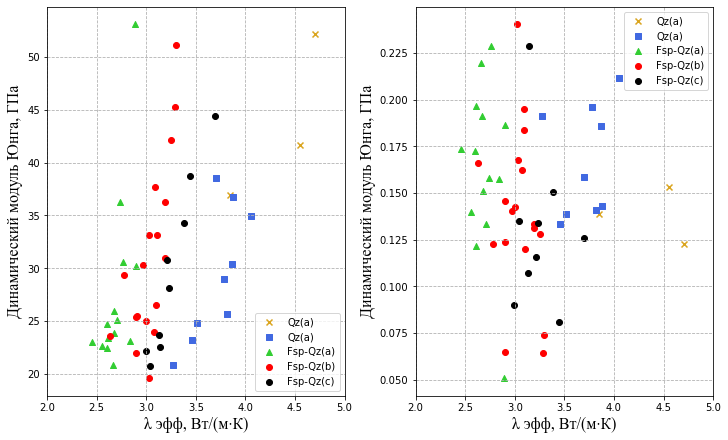

In [ ]:
fig4 = plt.figure(layout='constrained', figsize=(10, 6))
ax = fig4.subplots(1, 2, sharex=True)


x_value = "λ dry, W/(m·K)"
# ax.set_title(f'linear_width={a0:.3g}')
# ax.set_title(f'Porosity - λ ')
ax[0].scatter(df_qza[x_value], Ed_qza, label='Qz(a)', color='Goldenrod', marker='x')
ax[0].scatter(df_qzb[x_value], Ed_qzb, label='Qz(a)', color='RoyalBlue', marker='s')
ax[0].scatter(df_fspqz1[x_value], Ed_fspqz1, label='Fsp-Qz(a)',color='Limegreen', marker='^')
ax[0].scatter(df_fspqz2[x_value], Ed_fspqz2, label='Fsp-Qz(b)',color='Red', marker='o')
ax[0].scatter(df_fspqz3[x_value], Ed_fspqz3, label='Fsp-Qz(c)',color='Black', marker='o')


# ax.fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1, label='HS')


ax[0].set_xlabel('λ эфф, Вт/(м∙К)', fontsize=16, **csfont)
ax[0].set_ylabel('Динамический модуль Юнга, ГПа', fontsize=16, **csfont)
ax[0].grid(which='major', axis='both', linestyle='--')
ax[0].set_xlim([2, 5])
ax[0].set_xticks(np.arange(2, 5.1, 0.5), fontsize=20, **csfont)
ax[0].legend()


# ax.set_title(f'linear_width={a0:.3g}')
# ax.set_title(f'Porosity - λ ')
ax[1].scatter(df_qza[x_value], mu_qza, label='Qz(a)', color='Goldenrod', marker='x')
ax[1].scatter(df_qzb[x_value], mu_qzb, label='Qz(a)', color='RoyalBlue', marker='s')
ax[1].scatter(df_fspqz1[x_value], mu_fspqz1, label='Fsp-Qz(a)',color='Limegreen', marker='^')
ax[1].scatter(df_fspqz2[x_value], mu_fspqz2, label='Fsp-Qz(b)',color='Red', marker='o')
ax[1].scatter(df_fspqz3[x_value], mu_fspqz3, label='Fsp-Qz(c)',color='Black', marker='o')


# ax.fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1, label='HS')


ax[1].set_ylabel('Динамический модуль Юнга, ГПа', fontsize=16, **csfont)
ax[1].set_xlabel('λ эфф, Вт/(м∙К)', fontsize=16, **csfont)
ax[1].grid(which='major', axis='both', linestyle='--')
ax[1].set_xlim([2, 5])
ax[1].set_xticks(np.arange(2, 5.1, 0.5), fontsize=20, **csfont)
ax[1].legend()


plt.show()


![image.png](attachment:image.png)

In [ ]:
#Estat = 0.033Edyn + 0.0065
Estat = 0.74*Ed_qza-0.82

In [ ]:
Ed_qza, Estat

(3    36.900283
 4    41.683295
 5    52.203270
 dtype: float64,
 3    26.486209
 4    30.025638
 5    37.810420
 dtype: float64)

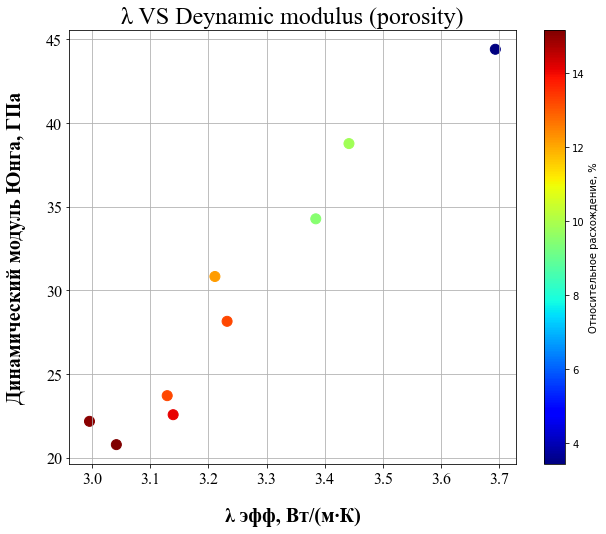

In [ ]:

# Without delte duplicate values in rows
x_values, y_values = df_fspqz3["λ dry, W/(m·K)"], Ed_fspqz3

csfont = {'fontname':'Times New Roman'}
fig,ax = plt.subplots(figsize=(10, 8))
plt.grid(True)

z_values = "Hydrostatic"
plt.scatter(x=x_values,
            y=y_values,
            c = abs(df_fspqz3[z_values]),
            vmin=abs(df_fspqz3[z_values]).min(),
            vmax=abs(df_fspqz3[z_values]).max(),
            cmap='jet',
            s=100)

# plt.xlim(10**-3., 10**0.)
# For the y axis, we need to flip by passing in the scale values in reverse order
# plt.ylim(2.30, 2.40)
# Add in labels for the axes
plt.ylabel('Динамический модуль Юнга, ГПа', fontsize=20, **csfont, fontweight='bold', labelpad=20)
plt.xlabel('λ эфф, Вт/(м∙К)', fontsize=20, **csfont, fontweight='bold', labelpad=20)
plt.xticks(fontsize=16, **csfont)
plt.yticks(fontsize=16, **csfont)

# Make the colorbar show
plt.colorbar(label='Относительное расхождение, %')
plt.title('λ VS Deynamic modulus (porosity)', **csfont, fontsize=24)
# plt.xscale("log")
plt.grid(True, which="both", ls="-")
plt.show()

In [ ]:
np.logspace(-1.25, 0, num=10, base=10)

array([0.05623413, 0.07742637, 0.10660505, 0.14677993, 0.20209499,
       0.27825594, 0.38311868, 0.52749971, 0.72629175, 1.        ])